# 라이브러리

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (14,16)

# 함수 모음

In [2]:
def text_preprocess(text):
    text = str(text)
    prepro_text = re.sub(r'[^가-힣A-Za-z]', ' ', text)
    return prepro_text


def tokenize(text):
    okt = Okt()
    tokens = okt.pos(text)
    new_words = []
    for word,tag in tokens:
        if tag not in ['Josa', 'Suffix']:
            new_words.append(word)
    result = ' '.join(new_words)
    return result


def age_change(age):
    if age < 20:
        result = 1
    elif age < 30:
        result = 2
    elif age < 40:
        result = 3
    elif age < 50:
        result = 4
    elif age < 60:
        result = 5
    else:
        result = 6
    return result


def location_change(location):
    # 수도권(1)
    if location in [1, 8, 4]:
        result = 1
    # 충청권(2)
    elif location in [6, 10, 11,17]:
        result = 2
    # 전라권(3)
    elif location in [5, 12, 13]:
        result = 3
    # 경상권(4)
    elif location in [2, 3, 7, 14, 15]:
        result = 4
    # 강원권(5)
    elif location in [9]:
        result = 5
    # 제주권(6)
    elif location in [16]:
        result = 6
    return result


# 빈도 분석 단어 추출
def count_vectorizer(text, vectorizer, num):
    vectorizer = vectorizer.fit(text)
    voca = sorted(vectorizer.vocabulary_.items())
    idx2word = {idx: word for word, idx in voca}

    total_word = []
    total_word.append((' ').join(text))

    count_matrix = vectorizer.transform(total_word)

    count_word = []
    count_vec = []

    for i in range(num,0,-1):
        count_word.append(idx2word[(-count_matrix.toarray()[0]).argsort()[i-1]])
        count_vec.append(count_matrix.toarray()[0][(-count_matrix.toarray()[0]).argsort()[i-1]])

    return count_word, count_vec


# 단어 그래프
def bar_graph(word, vec, color, title):
    plt.barh(word, vec, label='빈도', color=color)
    plt.ylabel('단어')
    plt.xlabel('빈도')
    plt.title('{} 텍스트 분석'.format(title))
    plt.yticks(word)
    plt.legend()
    plt.tight_layout()
    plt.show()


# tfidf 코사인 유사도 대표문장
def tfidf_cosine(selected_word, total_text, raw_data1, raw_data2, vectorizer, extract_num):

    # vectorizer 학습 시키기
    vectorizer = vectorizer.fit(total_text)

    # 유사도 확인할 단어들 시리즈로 만들기
    new_text = pd.Series(selected_word)
    
    # 텍스트를 counter vectorizer를 활용하여 숫자로 바꾸기
    selected_word_vec = vectorizer.transform(new_text)
    docs_vec = vectorizer.transform(total_text)

    # 코사인 유사도 만들기
    cosine_sim = cosine_similarity(selected_word_vec, docs_vec)

    # 유사도 높은 순위 5개 추출
    cosine_num = []
    keywords = []
    esg_company = []
    for num in np.arange(-1, extract_num, -1):
        cosine_num.append(cosine_sim[0][cosine_sim[0].argsort()[num]])
        keywords.append(raw_data2.iloc[cosine_sim[0].argsort()[num]])
        esg_company.append(raw_data1.iloc[cosine_sim[0].argsort()[num]])

    new_df = pd.DataFrame({
        'ESG기업' : esg_company,
        '대표문장' : keywords,
        '코사인유사도': cosine_num
    })
    return new_df


# 대표 문장 추출
def rep_texts(selected_words, total_text, raw_data1, raw_data2, vectorizer, text_class):
    rep_df = pd.DataFrame(
        columns = ['선택단어', '선택ESG기업', '{} 대표문장'.format(text_class), '코사인유사도']
    )
    for word in selected_words[::-1]:
        cosine_df = tfidf_cosine(word, total_text, raw_data1, raw_data2, vectorizer, -6)
        cosine_df.insert(0, '선택단어', [word, np.nan,np.nan,np.nan,np.nan], True)
        cosine_df.columns = rep_df.columns
        rep_df = rep_df.append(cosine_df, ignore_index=True)
    
    return rep_df


# 데이터 로드

In [ ]:
path = './ESG_이벤트_Rawdata.xlsx'
df = pd.read_excel(path)
df

# 데이터 정제

In [4]:
new_df = df.copy()
new_df['Q1t1'] = new_df['Q1t1'].map(text_preprocess).map(tokenize)
new_df['Q2t1'] = new_df['Q2t1'].map(text_preprocess).map(tokenize)

# 데이터 분리

In [16]:
# 전체 ESG 실천 기업(Q1)
total_q1 = new_df['Q1t1']
# 전체 '왜 잘하고 있다고 생각하는지'(Q2)
total_q2 = new_df['Q2t1']

# 전체 raw data
q1_raw_data = df['Q1t1']
q2_raw_data = df['Q2t1']


#######################################################################


# 성별
# 남자 Q1 & Q2
male_q1 = new_df['Q1t1'][new_df['SQ1']==1]
male_q2 = new_df['Q2t1'][new_df['SQ1']==1]
male_raw_data_q1 = df['Q1t1'][df['SQ1']==1]
male_raw_data_q2 = df['Q2t1'][df['SQ1']==1]

# 여자 Q1 & Q2
female_q1 = new_df['Q1t1'][new_df['SQ1']==2]
female_q2 = new_df['Q2t1'][new_df['SQ1']==2]
female_raw_data_q1 = df['Q1t1'][df['SQ1']==2]
female_raw_data_q2 = df['Q2t1'][df['SQ1']==2]


#######################################################################


# 연령별
total_age = new_df[['Q1t1', 'Q2t1', 'SQ2t2']][new_df['SQ2t2'] != '/NA/']
total_age['SQ2t2'] = total_age['SQ2t2'].astype(np.int64)
total_age['SQ2t2'] = total_age['SQ2t2'].map(age_change)
# 연령별 total raw
age_total_raw = df[['Q1t1', 'Q2t1', 'SQ2t2']][df['SQ2t2']!= '/NA/']
age_total_raw['SQ2t2'] = age_total_raw['SQ2t2'].astype(np.int64).map(age_change)

# 10대 Q1 & Q2
age10_q1 = total_age['Q1t1'][total_age['SQ2t2'] == 1]
age10_q2 = total_age['Q2t1'][total_age['SQ2t2'] == 1]
age10_raw_data_q1 = age_total_raw['Q1t1'][age_total_raw['SQ2t2']==1]
age10_raw_data_q2 = age_total_raw['Q2t1'][age_total_raw['SQ2t2']==1]


# 20대 Q1 & Q2
age20_q1 = total_age['Q1t1'][total_age['SQ2t2'] == 2]
age20_q2 = total_age['Q2t1'][total_age['SQ2t2'] == 2]
age20_raw_data_q1 = age_total_raw['Q1t1'][age_total_raw['SQ2t2']==2]
age20_raw_data_q2 = age_total_raw['Q2t1'][age_total_raw['SQ2t2']==2]


# 30대 Q1 & Q2
age30_q1 = total_age['Q1t1'][total_age['SQ2t2'] == 3]
age30_q2 = total_age['Q2t1'][total_age['SQ2t2'] == 3]
age30_raw_data_q1 = age_total_raw['Q1t1'][age_total_raw['SQ2t2']==3]
age30_raw_data_q2 = age_total_raw['Q2t1'][age_total_raw['SQ2t2']==3]


# 40대 Q1 & Q2
age40_q1 = total_age['Q1t1'][total_age['SQ2t2'] == 4]
age40_q2 = total_age['Q2t1'][total_age['SQ2t2'] == 4]
age40_raw_data_q1 = age_total_raw['Q1t1'][age_total_raw['SQ2t2']==4]
age40_raw_data_q2 = age_total_raw['Q2t1'][age_total_raw['SQ2t2']==4]


# 50대 Q1 & Q2
age50_q1 = total_age['Q1t1'][total_age['SQ2t2'] == 5]
age50_q2 = total_age['Q2t1'][total_age['SQ2t2'] == 5]
age50_raw_data_q1 = age_total_raw['Q1t1'][age_total_raw['SQ2t2']==5]
age50_raw_data_q2 = age_total_raw['Q2t1'][age_total_raw['SQ2t2']==5]


# 60대 이상 Q1 & Q2
age60_q1 = total_age['Q1t1'][total_age['SQ2t2'] == 6]
age60_q2 = total_age['Q2t1'][total_age['SQ2t2'] == 6]
age60_raw_data_q1 = age_total_raw['Q1t1'][age_total_raw['SQ2t2']==6]
age60_raw_data_q2 = age_total_raw['Q2t1'][age_total_raw['SQ2t2']==6]

#######################################################################

# 지역별
total_location = new_df[['Q1t1', 'Q2t1', 'Q2_1']]
total_location['Q2_1'] = total_location['Q2_1'].map(location_change)
# 지역별 total raw
location_total_raw = df[['Q1t1', 'Q2t1', 'Q2_1']]
location_total_raw['Q2_1'] = location_total_raw['Q2_1'].map(location_change)


# 수도권(1) Q1 & Q2
sudo_q1 = total_location['Q1t1'][total_location['Q2_1'] == 1]
sudo_q2 = total_location['Q2t1'][total_location['Q2_1'] == 1]
sudo_q1_raw = location_total_raw['Q1t1'][location_total_raw['Q2_1'] == 1]
sudo_q2_raw = location_total_raw['Q2t1'][location_total_raw['Q2_1'] == 1]


# 충청권(2) Q1 & Q2
choong_q1 = total_location['Q1t1'][total_location['Q2_1'] == 2]
choong_q2 = total_location['Q2t1'][total_location['Q2_1'] == 2]
choong_q1_raw = location_total_raw['Q1t1'][location_total_raw['Q2_1'] == 2]
choong_q2_raw = location_total_raw['Q2t1'][location_total_raw['Q2_1'] == 2]

# 전라권(3) Q1 & Q2
junla_q1 = total_location['Q1t1'][total_location['Q2_1'] == 3]
junla_q2 = total_location['Q2t1'][total_location['Q2_1'] == 3]
junla_q1_raw = location_total_raw['Q1t1'][location_total_raw['Q2_1'] == 3]
junla_q2_raw = location_total_raw['Q2t1'][location_total_raw['Q2_1'] == 3]

# 경상권(4) Q1 & Q2
kyung_q1 = total_location['Q1t1'][total_location['Q2_1'] == 4]
kyung_q2 = total_location['Q2t1'][total_location['Q2_1'] == 4]
kyung_q1_raw = location_total_raw['Q1t1'][location_total_raw['Q2_1'] == 4]
kyung_q2_raw = location_total_raw['Q2t1'][location_total_raw['Q2_1'] == 4]

# 강원권(5) Q1 & Q2
kang_q1 = total_location['Q1t1'][total_location['Q2_1'] == 5]
kang_q2 = total_location['Q2t1'][total_location['Q2_1'] == 5]
kang_q1_raw = location_total_raw['Q1t1'][location_total_raw['Q2_1'] == 5]
kang_q2_raw = location_total_raw['Q2t1'][location_total_raw['Q2_1'] == 5]

# 제주도(6) Q1 & Q2
jeju_q1 = total_location['Q1t1'][total_location['Q2_1'] == 6]
jeju_q2 = total_location['Q2t1'][total_location['Q2_1'] == 6]
jeju_q1_raw = location_total_raw['Q1t1'][location_total_raw['Q2_1'] == 6]
jeju_q2_raw = location_total_raw['Q2t1'][location_total_raw['Q2_1'] == 6]


C:\Users\Hi\AppData\Local\Temp/ipykernel_5484/2918131511.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_location['Q2_1'] = total_location['Q2_1'].map(location_change)
C:\Users\Hi\AppData\Local\Temp/ipykernel_5484/2918131511.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_total_raw['Q2_1'] = location_total_raw['Q2_1'].map(location_change)


# ESG 실천하고 있는 기업은? (Q1)
# 어떤 ESG를 잘하고 있나?   (Q2)

In [6]:
q1_stop_words = ['없음', '자동차', '기업', '그룹', '모름', '엘지', '모르겠다', '마켓', '전자', '모르겠음', '생각',
'모르겠어요', '모르겠습니다', '없다', '없습니다']
q1_count = CountVectorizer(
    stop_words=q1_stop_words,
    max_features=50,
    ngram_range=(1,1)
)

In [7]:
q2_stop_words = ['하는', '생각', '합니다', '있기', '때문', '있다고', '최고', '기업', '대표', 
'문제', '해결', '대한', '하기', '위해', '만들기', '영향', '이루기', '수립', '중기', '목표', '분기', '대비', '동기']
q2_count = CountVectorizer(
    stop_words=q2_stop_words,
    max_features=50,
    ngram_range=(3,3),
    # min_df=20
)

In [8]:
# 성별

# 남자
male_q1_word, male_q1_vec = count_vectorizer(male_q1, q1_count, 10)
male_q2_word, male_q2_vec = count_vectorizer(male_q2, q2_count, 10)
# print(male_q2_word)

# 여자
female_q1_word, female_q1_vec = count_vectorizer(female_q1, q1_count, 10)
female_q2_word, female_q2_vec = count_vectorizer(female_q2, q2_count, 10)
# print(female_q2_word)

In [9]:
for idx, word in enumerate(female_q1_word):
    if word in ['당근']:
        female_q1_word[idx] = '당근마켓'

In [10]:
# 연령별

# 10대
age10_q1_word, age10_q1_vec = count_vectorizer(age10_q1, q1_count, 10)
age10_q2_word, age10_q2_vec = count_vectorizer(age10_q2, q2_count, 10)
# print(age10_q2_word)

# 20대
age20_q1_word, age20_q1_vec = count_vectorizer(age20_q1, q1_count, 10)
age20_q2_word, age20_q2_vec = count_vectorizer(age20_q2, q2_count, 10)
# print(age20_q2_word)

# 30대
age30_q1_word, age30_q1_vec = count_vectorizer(age30_q1, q1_count, 10)
age30_q2_word, age30_q2_vec = count_vectorizer(age30_q2, q2_count, 10)
# print(age30_q2_word)

# 40대
age40_q1_word, age40_q1_vec = count_vectorizer(age40_q1, q1_count, 10)
age40_q2_word, age40_q2_vec = count_vectorizer(age40_q2, q2_count, 10)
# print(age40_q2_word)

# 50대
age50_q1_word, age50_q1_vec = count_vectorizer(age50_q1, q1_count, 10)
age50_q2_word, age50_q2_vec = count_vectorizer(age50_q2, q2_count, 10)
# print(age50_q2_word)

# 60대 이상
age60_q1_word, age60_q1_vec = count_vectorizer(age60_q1, q1_count, 10)
age60_q2_word, age60_q2_vec = count_vectorizer(age60_q2, q2_count, 10)
# print(age60_q2_word)

In [11]:
for idx, word in enumerate(age10_q1_word):
    if word in ['당근']:
        age10_q1_word[idx] = '당근마켓'

for idx, word in enumerate(age20_q1_word):
    if word in ['당근']:
        age20_q1_word[idx] = '당근마켓'

In [12]:
# 지역별

# 수도권
sudo_q1_word, sudo_q1_vec = count_vectorizer(sudo_q1, q1_count, 10)
sudo_q2_word, sudo_q2_vec = count_vectorizer(sudo_q2, q2_count, 10)
# print(sudo_q2_word)

# 충청권
choong_q1_word, choong_q1_vec = count_vectorizer(choong_q1, q1_count, 10)
choong_q2_word, choong_q2_vec = count_vectorizer(choong_q2, q2_count, 10)
# print(choong_q2_word)

# 전라권
junla_q1_word, junla_q1_vec = count_vectorizer(junla_q1, q1_count, 10)
junla_q2_word, junla_q2_vec = count_vectorizer(junla_q2, q2_count, 10)
# print(junla_q2_word)

# 경상권
kyung_q1_word, kyung_q1_vec = count_vectorizer(kyung_q1, q1_count, 10)
kyung_q2_word, kyung_q2_vec = count_vectorizer(kyung_q2, q2_count, 10)
# print(kyung_q2_word)

# 강원권
kang_q1_word, kang_q1_vec = count_vectorizer(kang_q1, q1_count, 10)
kang_q2_word, kang_q2_vec = count_vectorizer(kang_q2, q2_count, 10)
# print(kang_q2_word)

# 제주권
jeju_q1_word, jeju_q1_vec = count_vectorizer(jeju_q1, q1_count, 10)
jeju_q2_word, jeju_q2_vec = count_vectorizer(jeju_q2, q2_count, 10)
# print(jeju_q2_word)

In [13]:
for idx, word in enumerate(kang_q1_word):
    if word in ['당근']:
        kang_q1_word[idx] = '당근마켓'

# 빈도 분석 막대 그래프

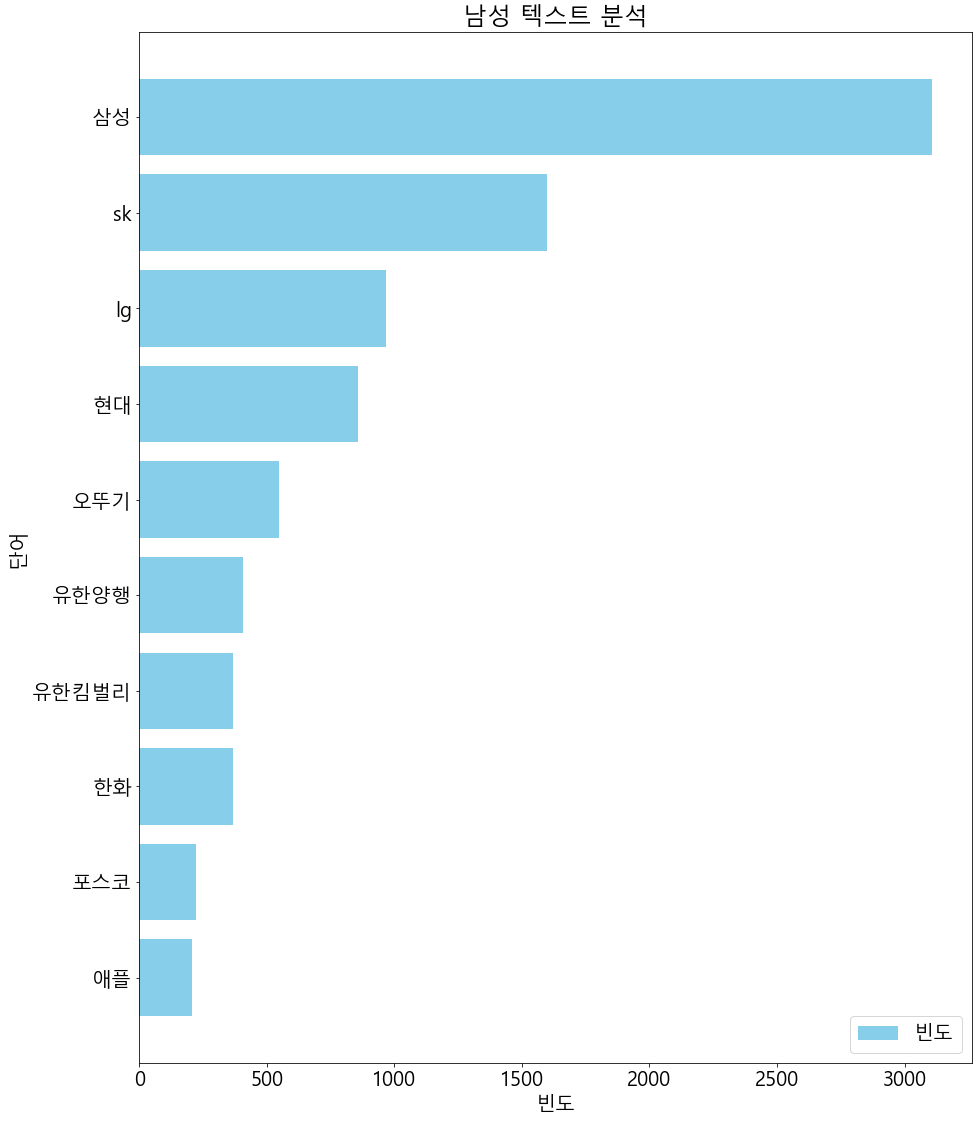

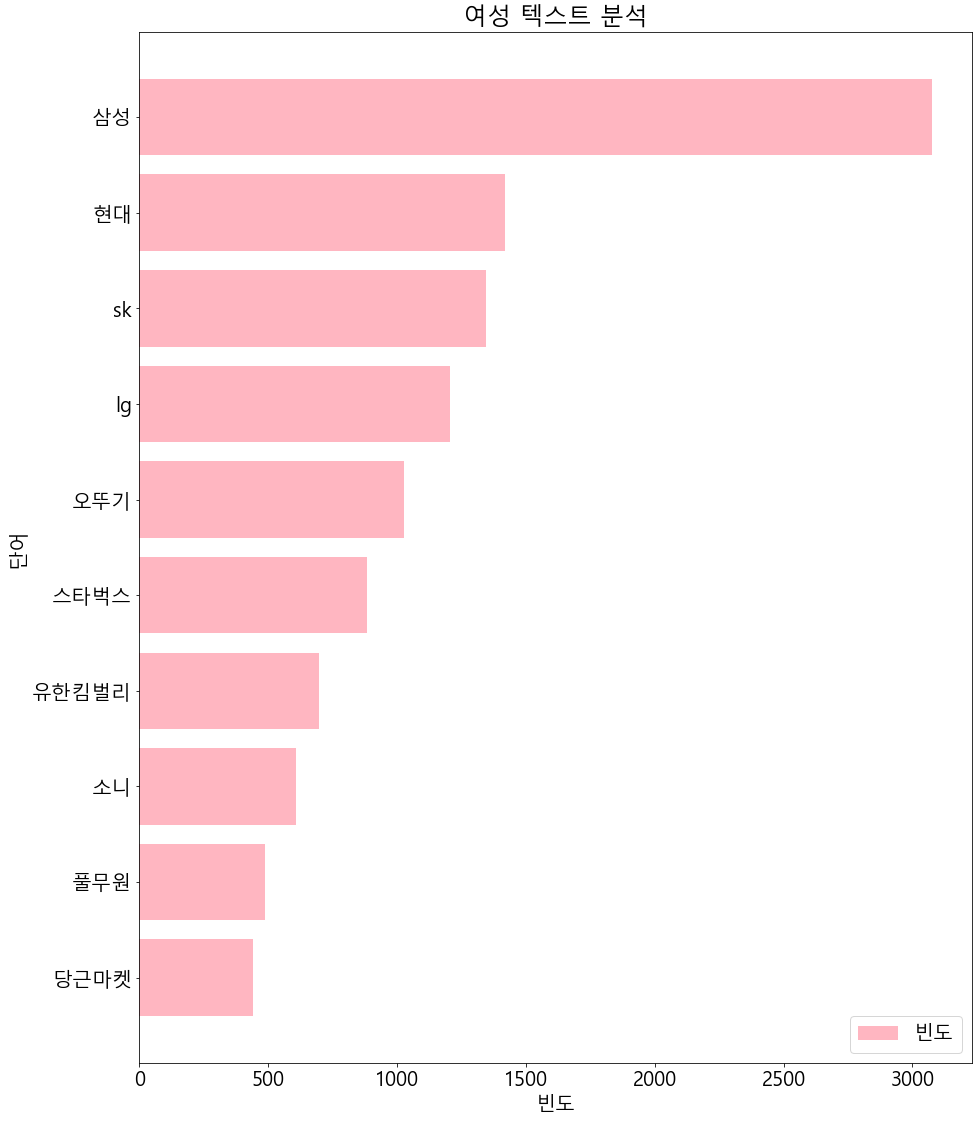

In [45]:
# Q1 성별
bar_graph(male_q1_word, male_q1_vec, 'skyblue', '남성')
bar_graph(female_q1_word, female_q1_vec, 'lightpink', '여성')

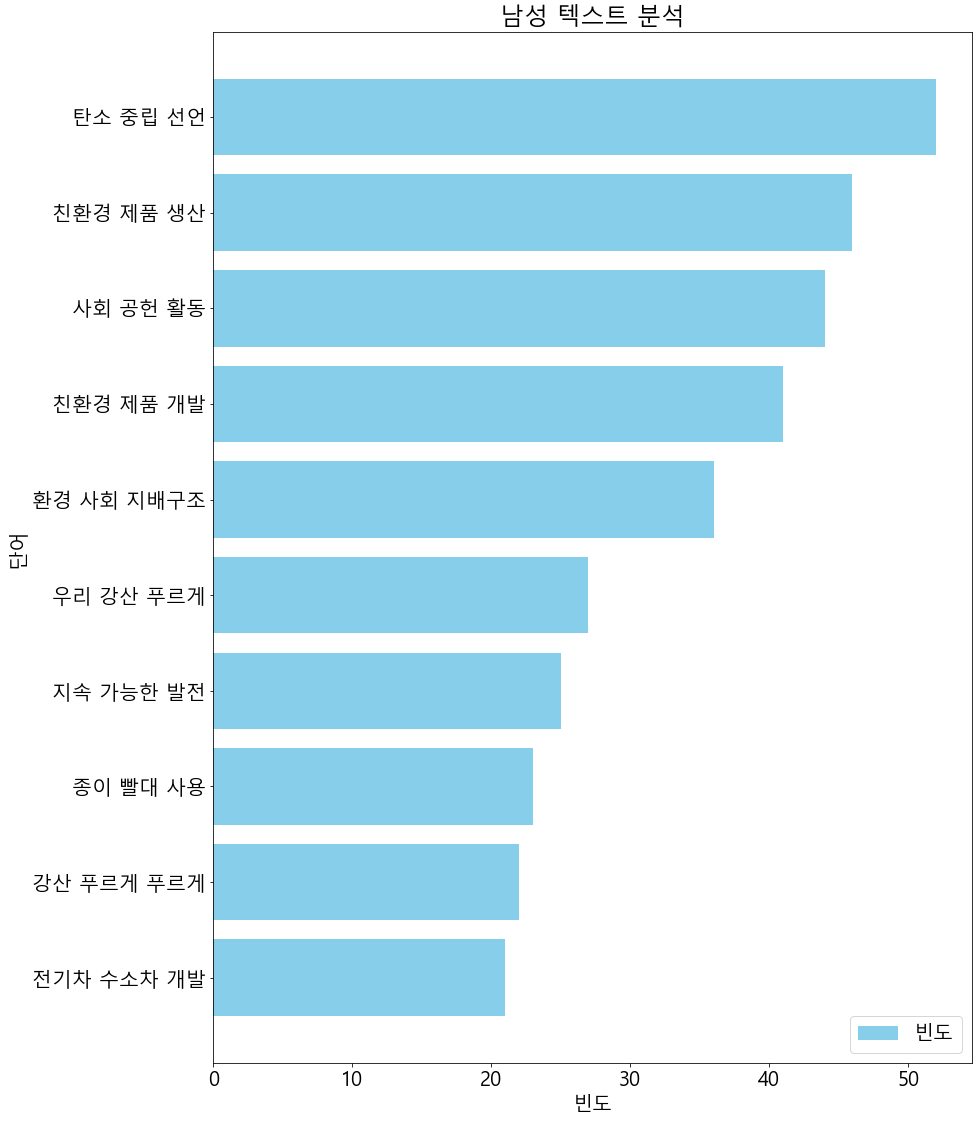

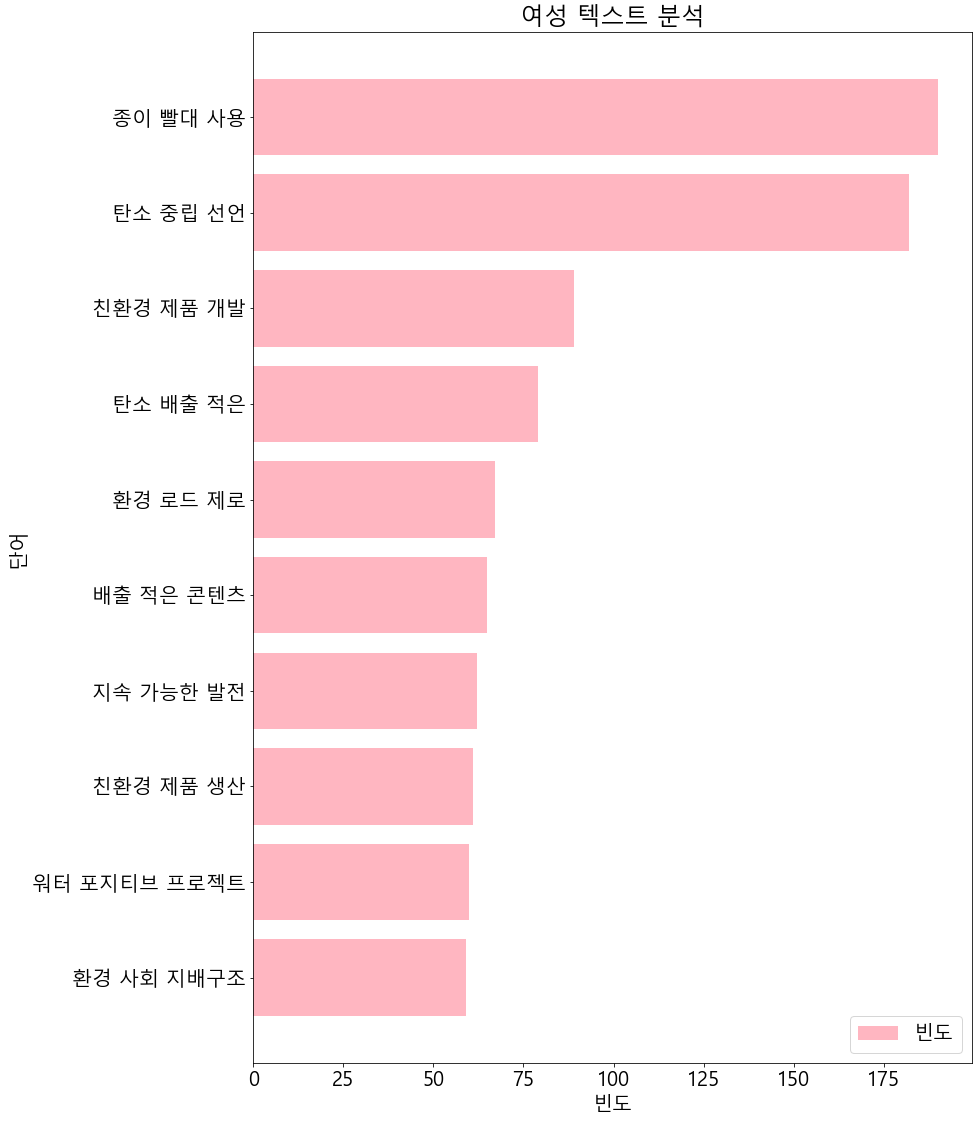

In [61]:
# Q2 성별
bar_graph(male_q2_word, male_q2_vec, 'skyblue', '남성')
bar_graph(female_q2_word, female_q2_vec, 'lightpink', '여성')

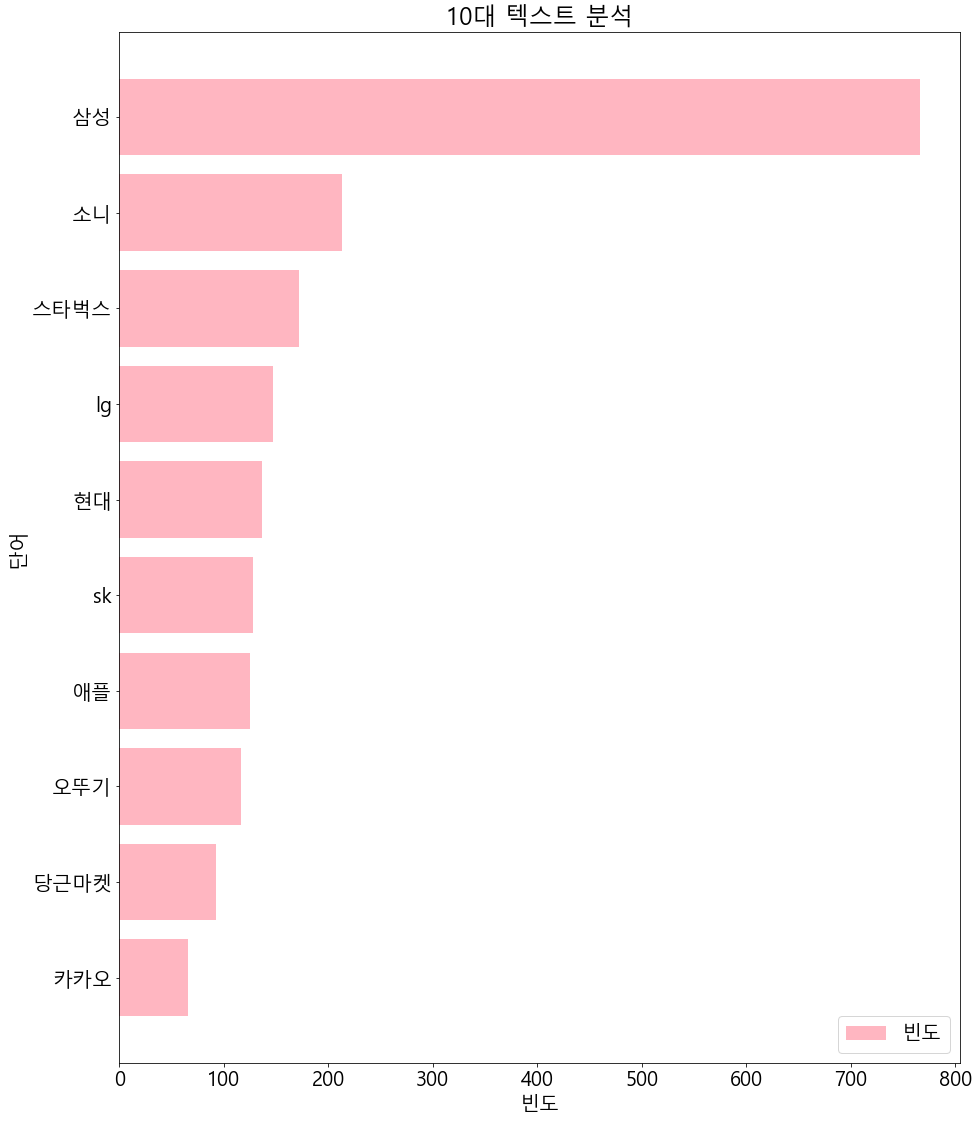

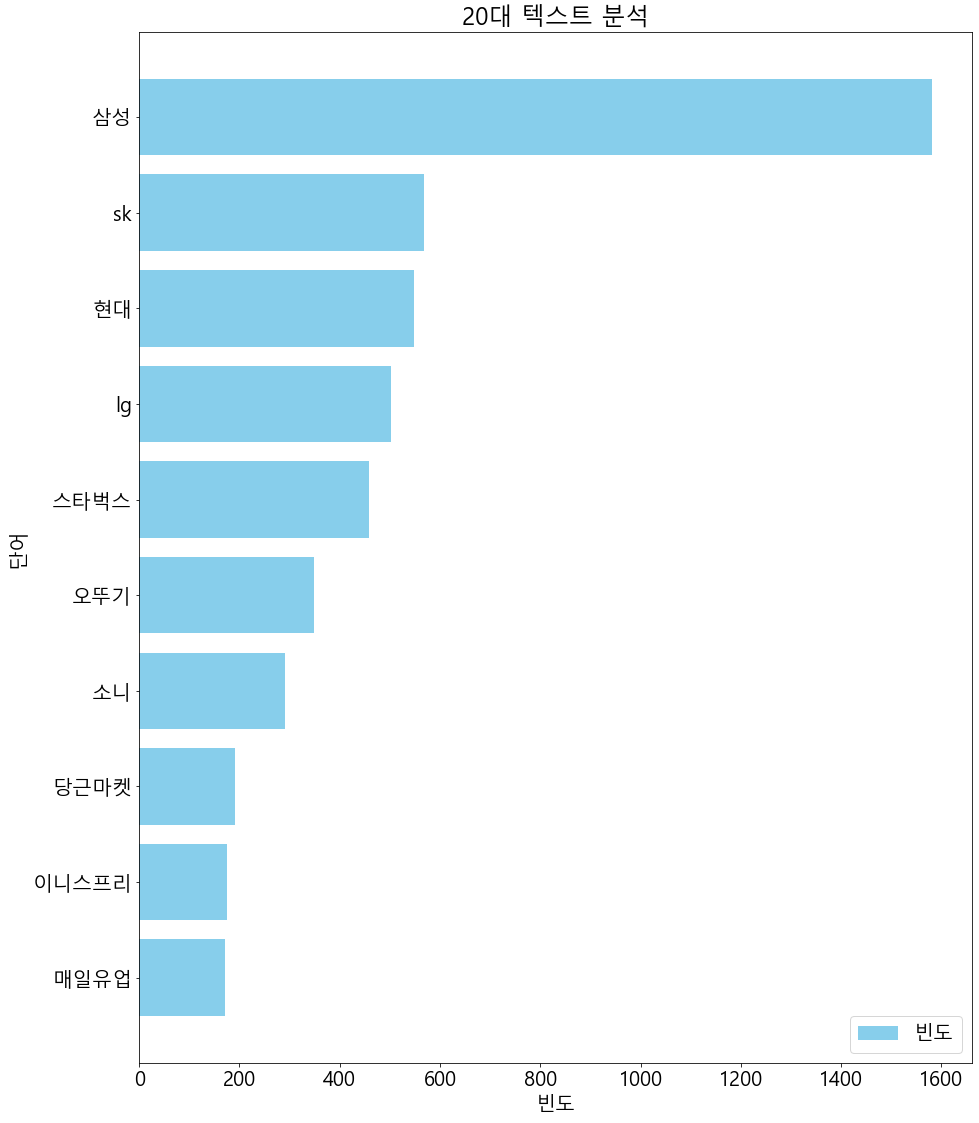

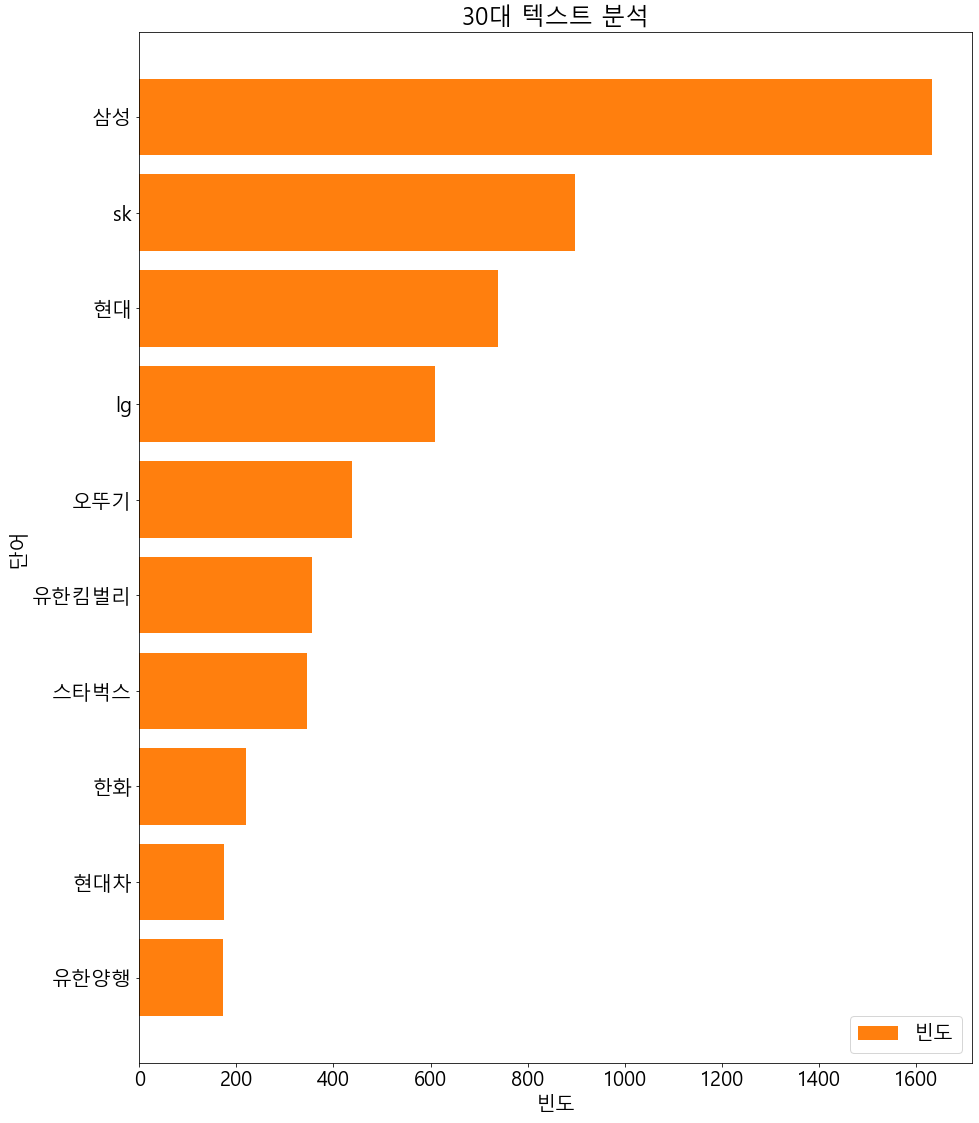

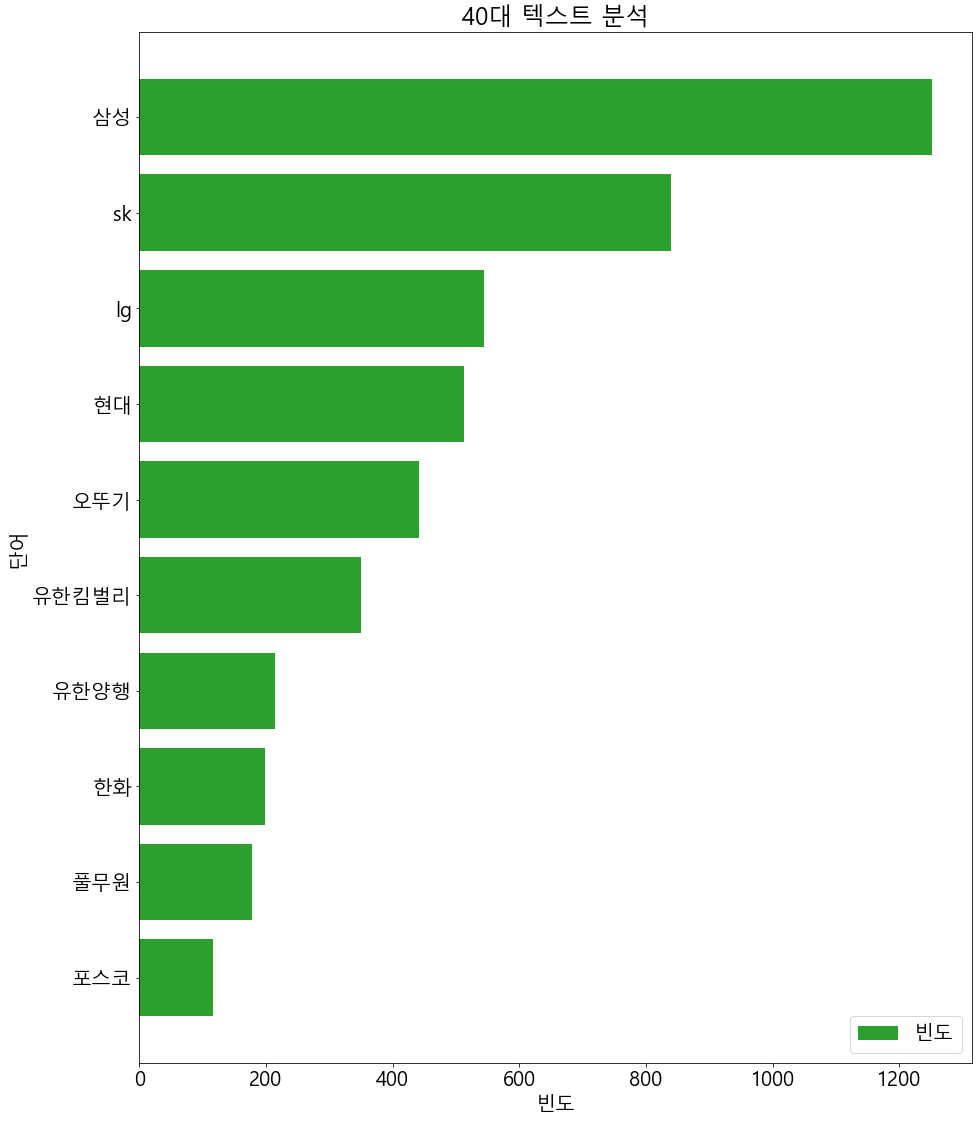

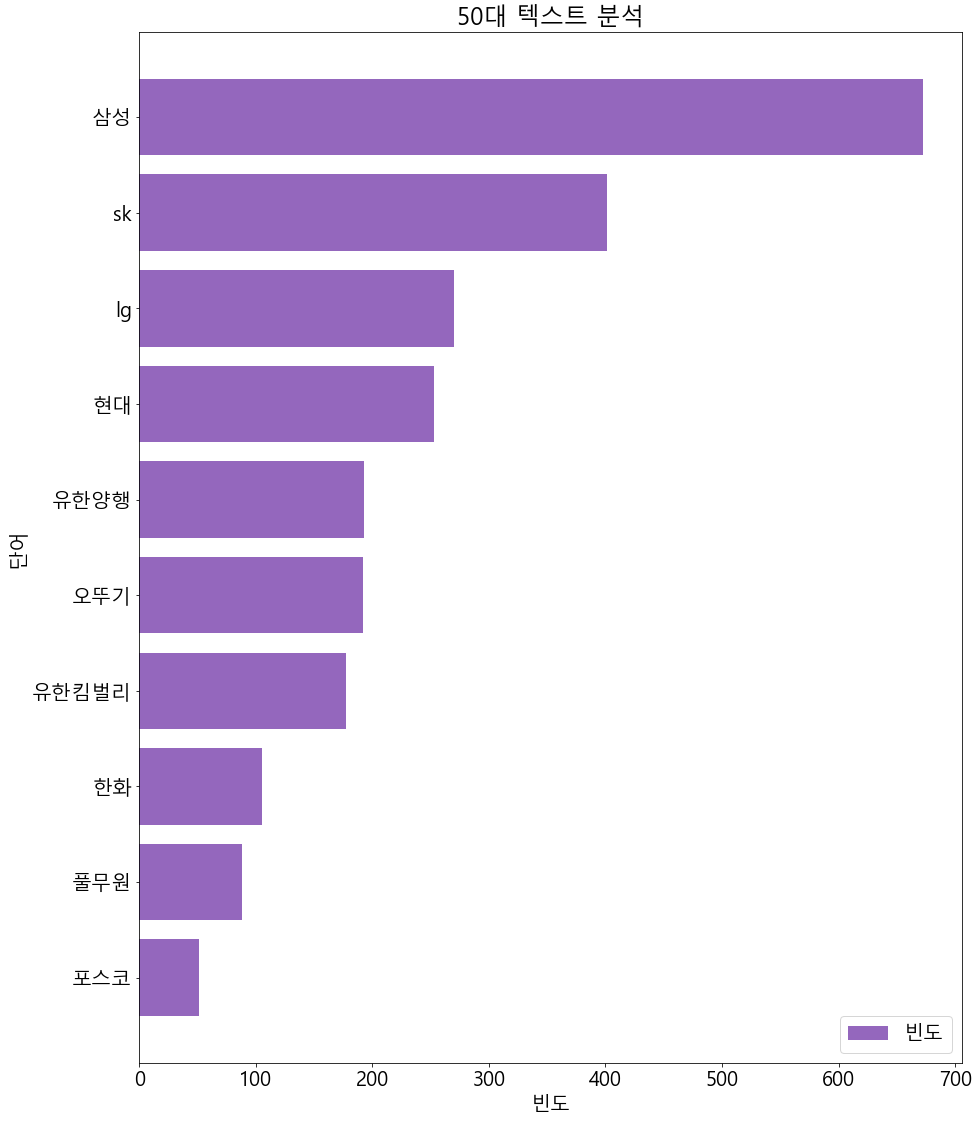

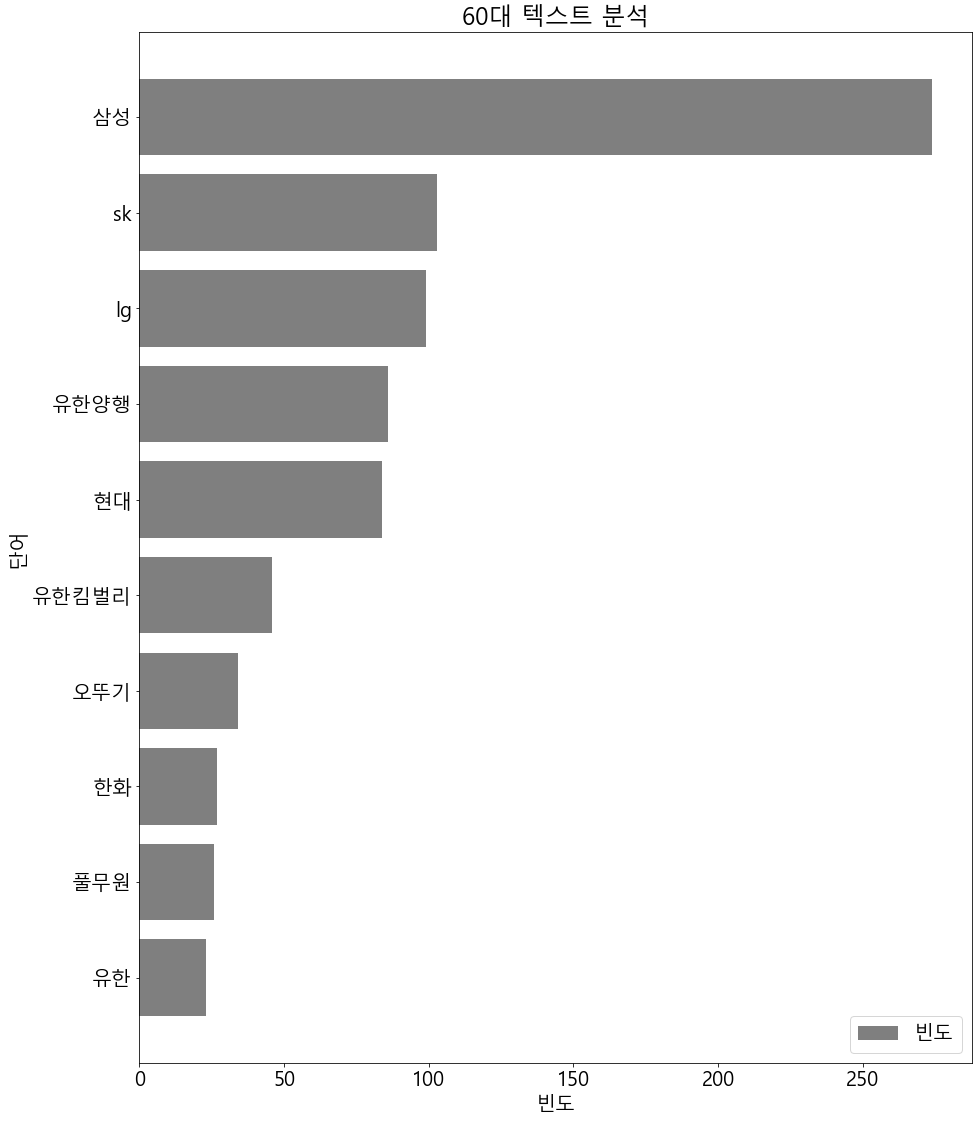

In [49]:
# Q1 연령별
bar_graph(age10_q1_word, age10_q1_vec, 'lightpink', '10대')
bar_graph(age20_q1_word, age20_q1_vec, 'skyblue', '20대')
bar_graph(age30_q1_word, age30_q1_vec, 'tab:orange', '30대')
bar_graph(age40_q1_word, age40_q1_vec, 'tab:green', '40대')
bar_graph(age50_q1_word, age50_q1_vec, 'tab:purple', '50대')
bar_graph(age60_q1_word, age60_q1_vec, 'tab:gray', '60대')

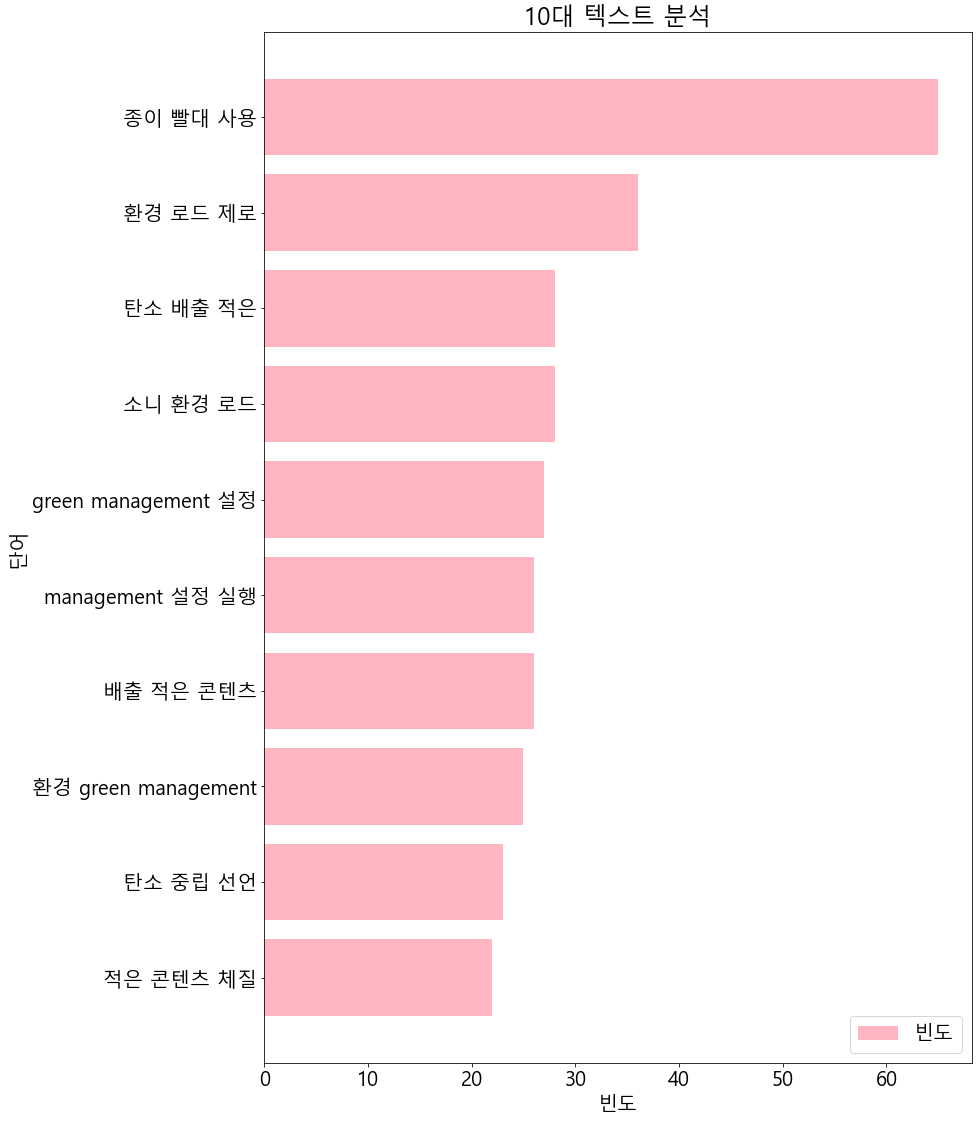

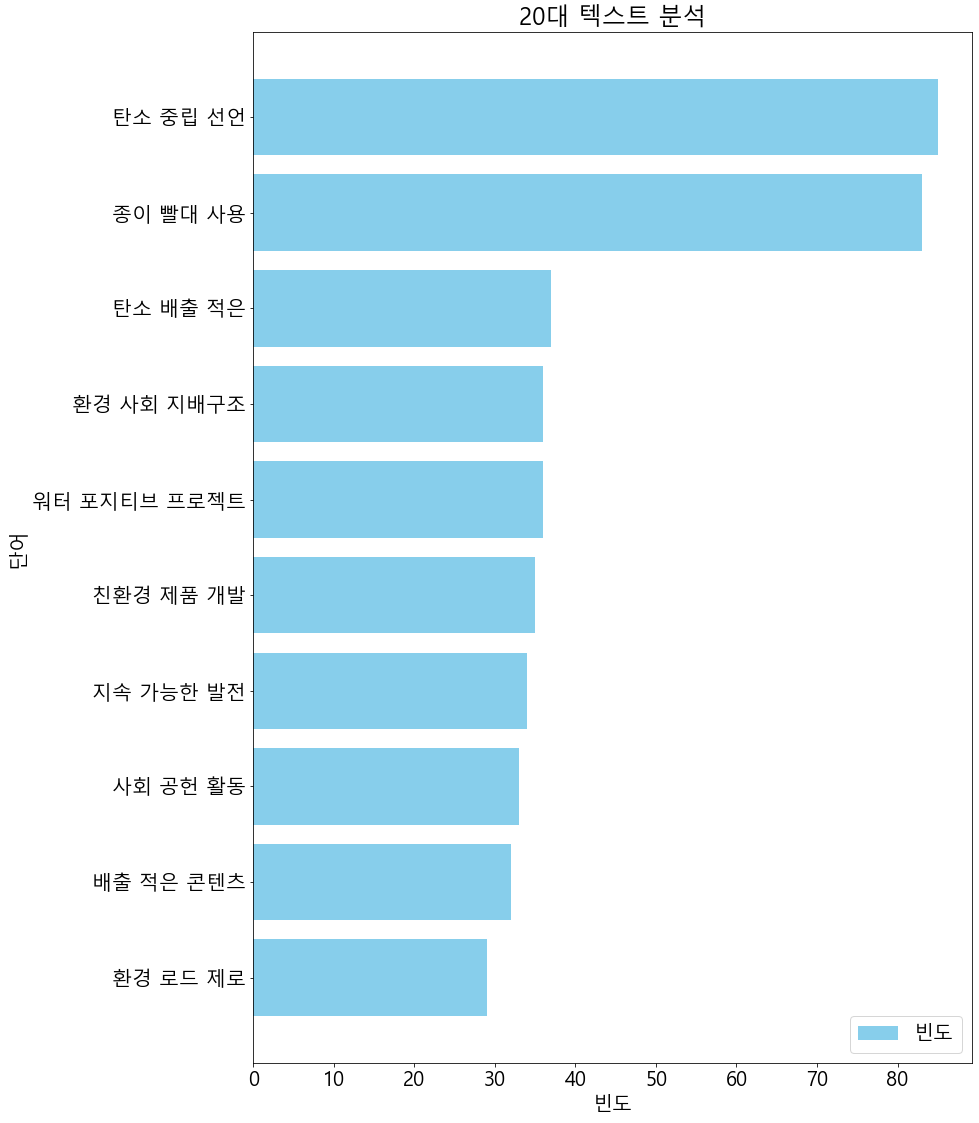

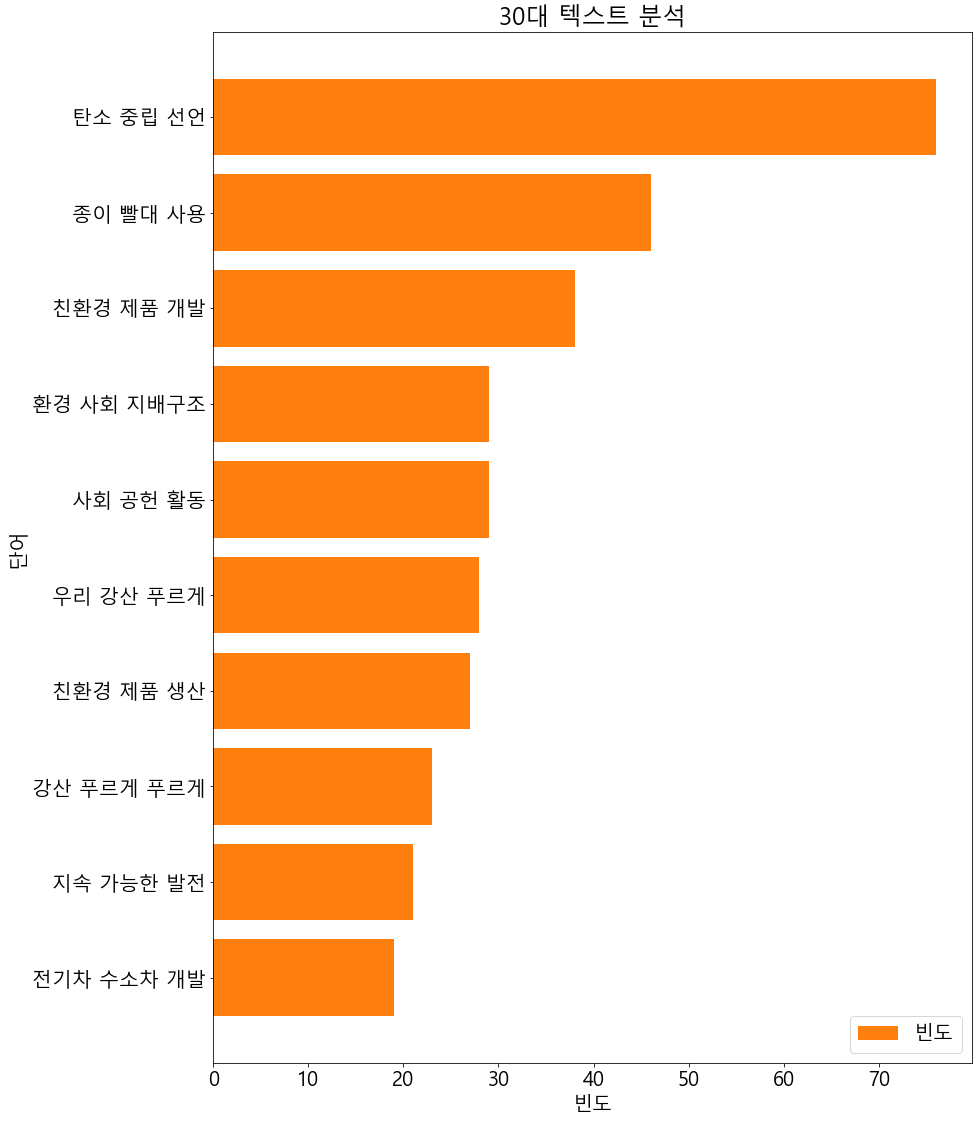

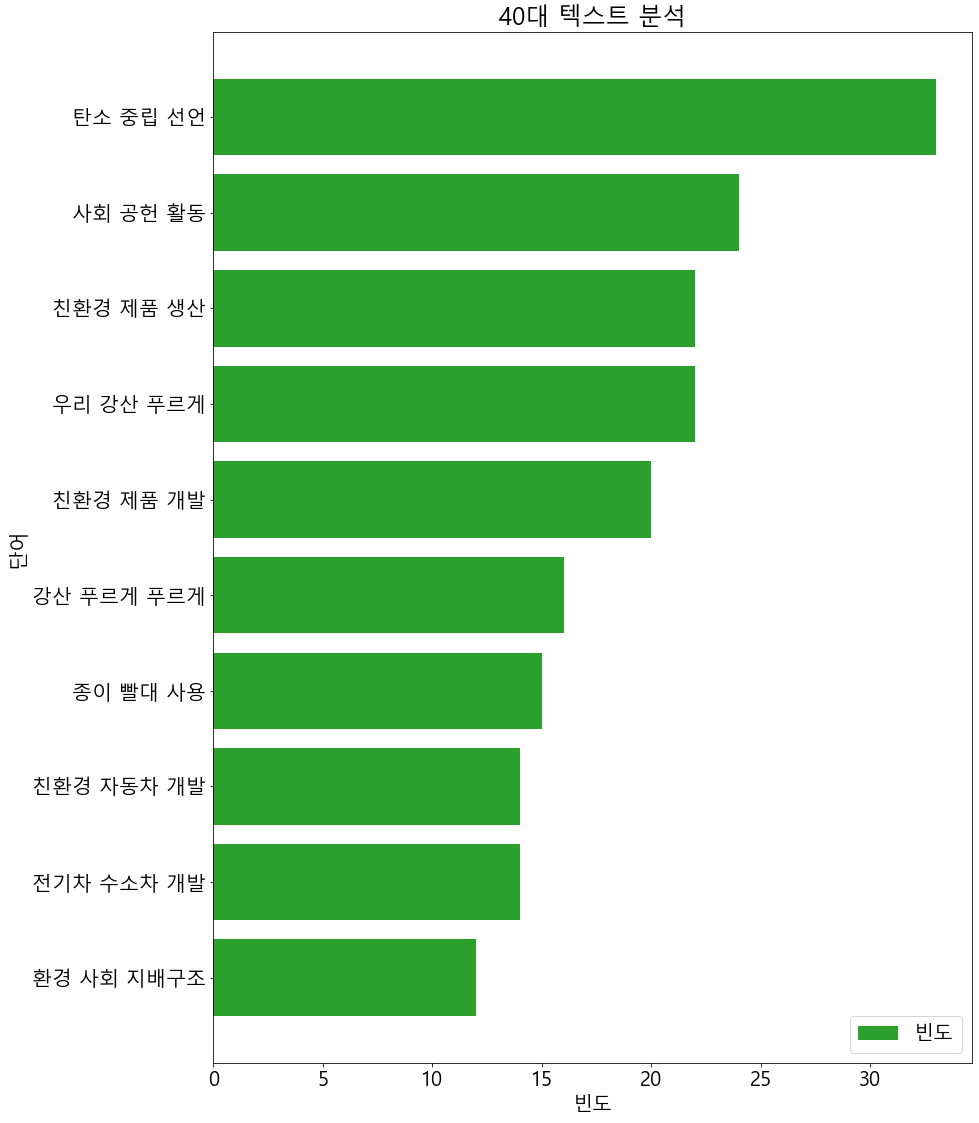

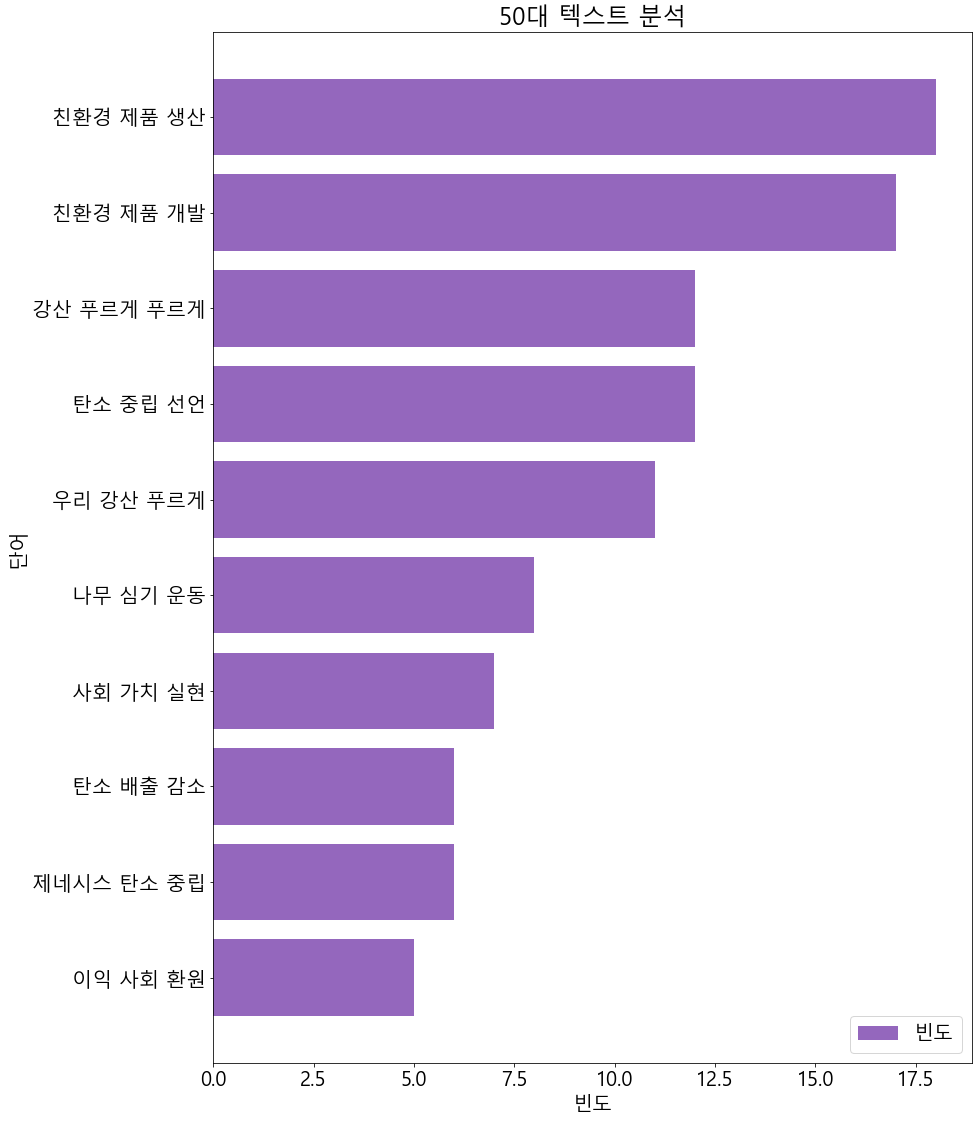

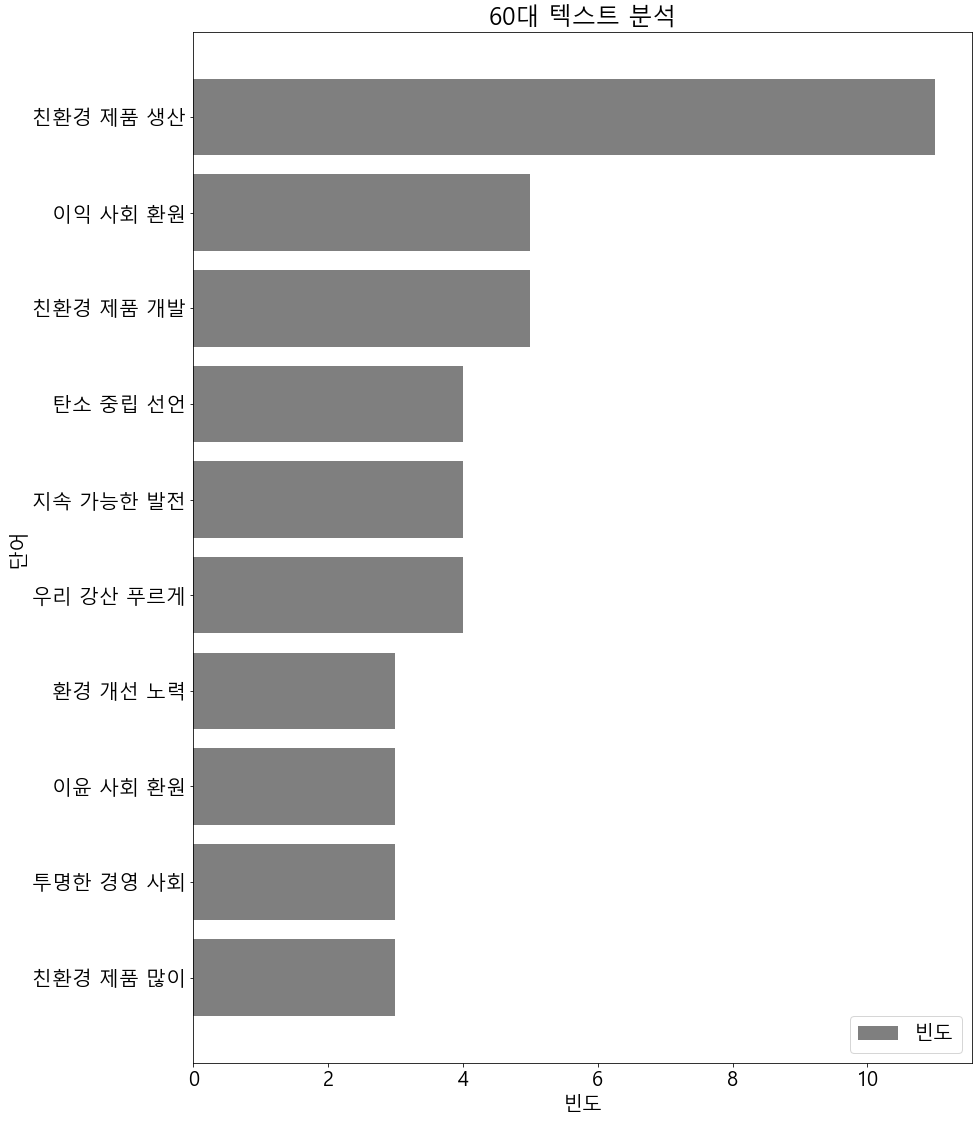

In [62]:
# Q2 연령별
bar_graph(age10_q2_word, age10_q2_vec, 'lightpink', '10대')
bar_graph(age20_q2_word, age20_q2_vec, 'skyblue', '20대')
bar_graph(age30_q2_word, age30_q2_vec, 'tab:orange', '30대')
bar_graph(age40_q2_word, age40_q2_vec, 'tab:green', '40대')
bar_graph(age50_q2_word, age50_q2_vec, 'tab:purple', '50대')
bar_graph(age60_q2_word, age60_q2_vec, 'tab:gray', '60대')

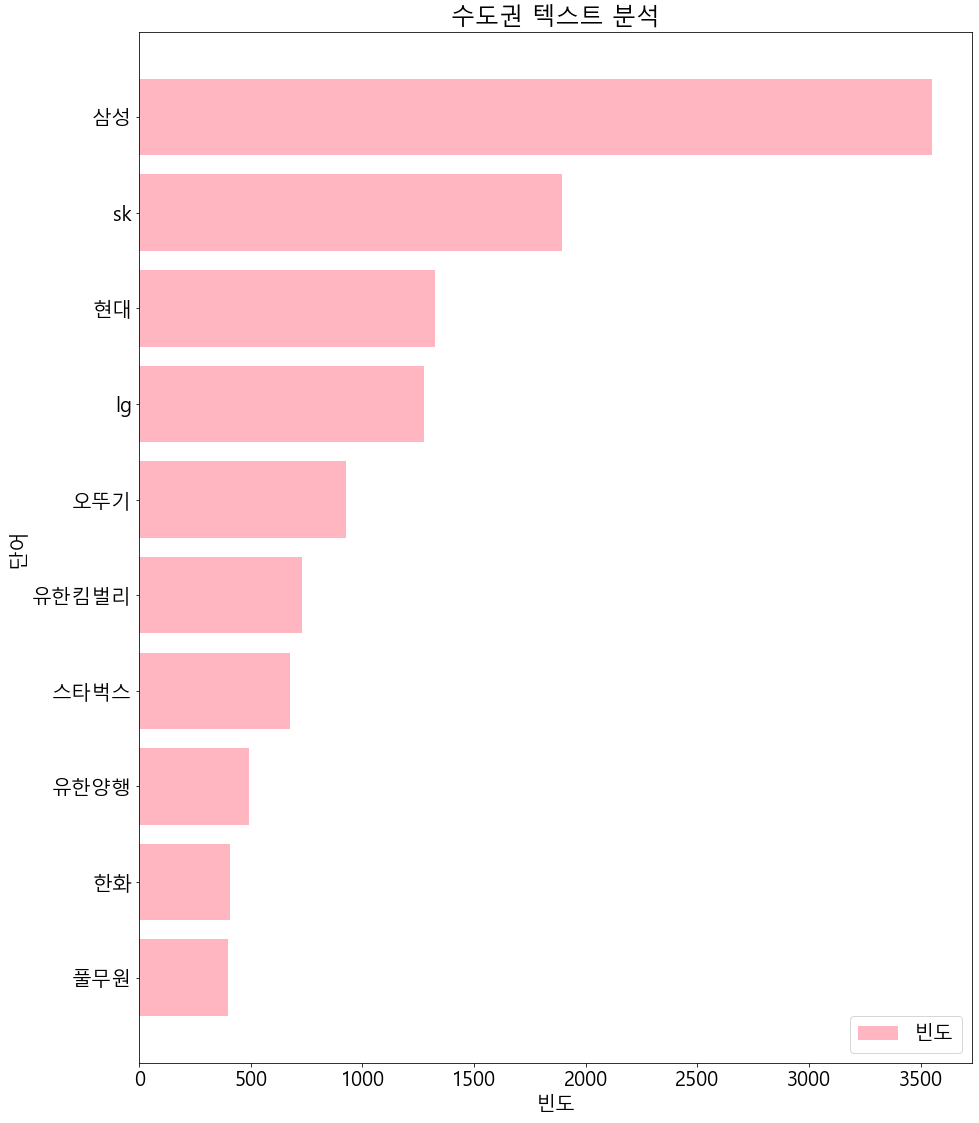

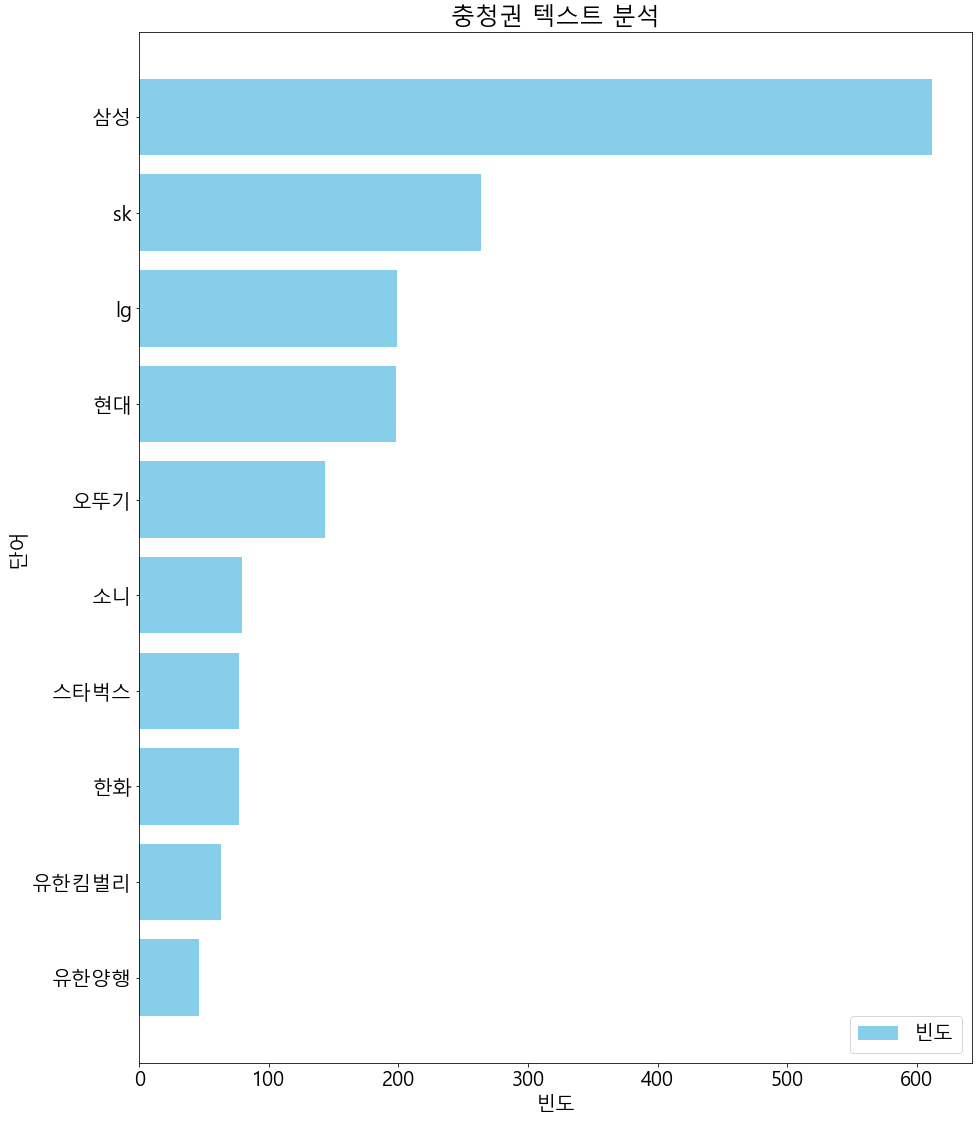

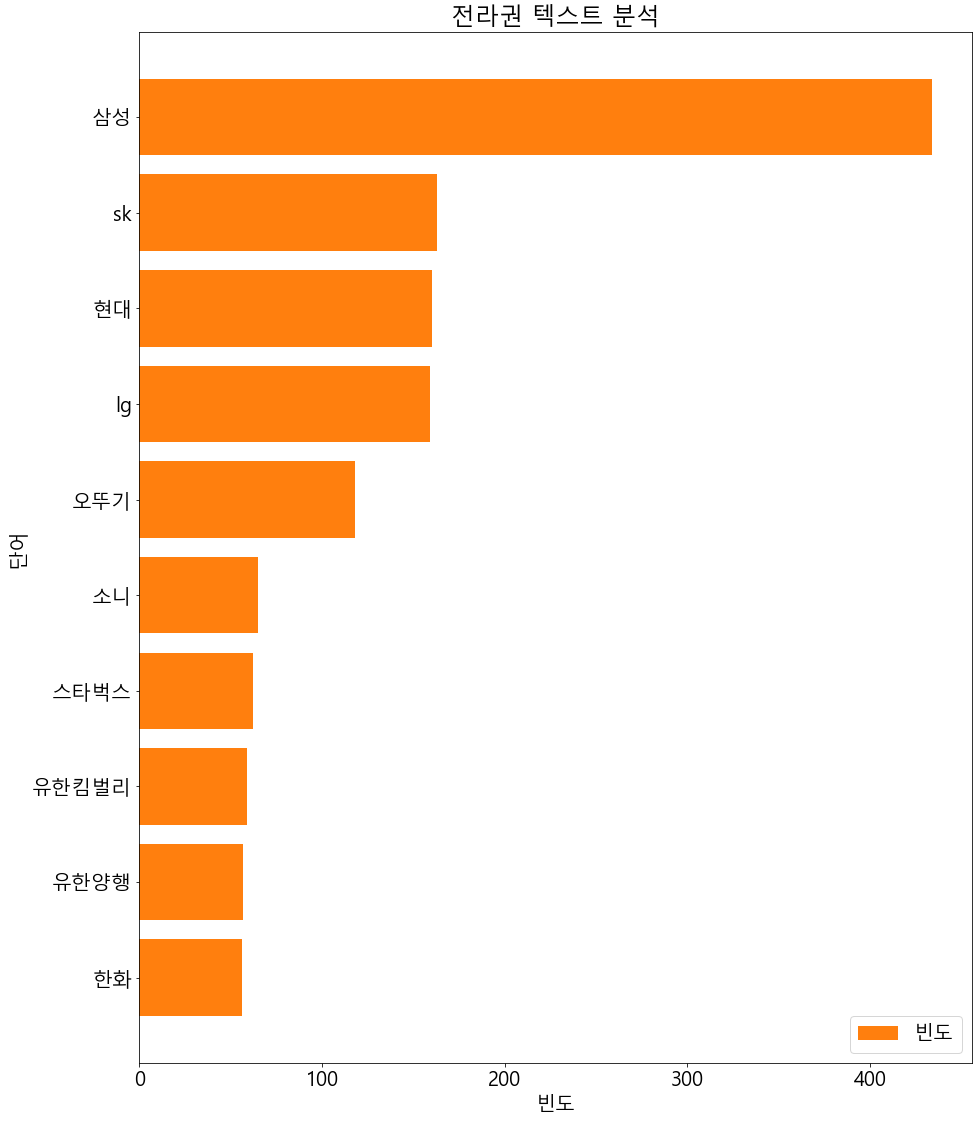

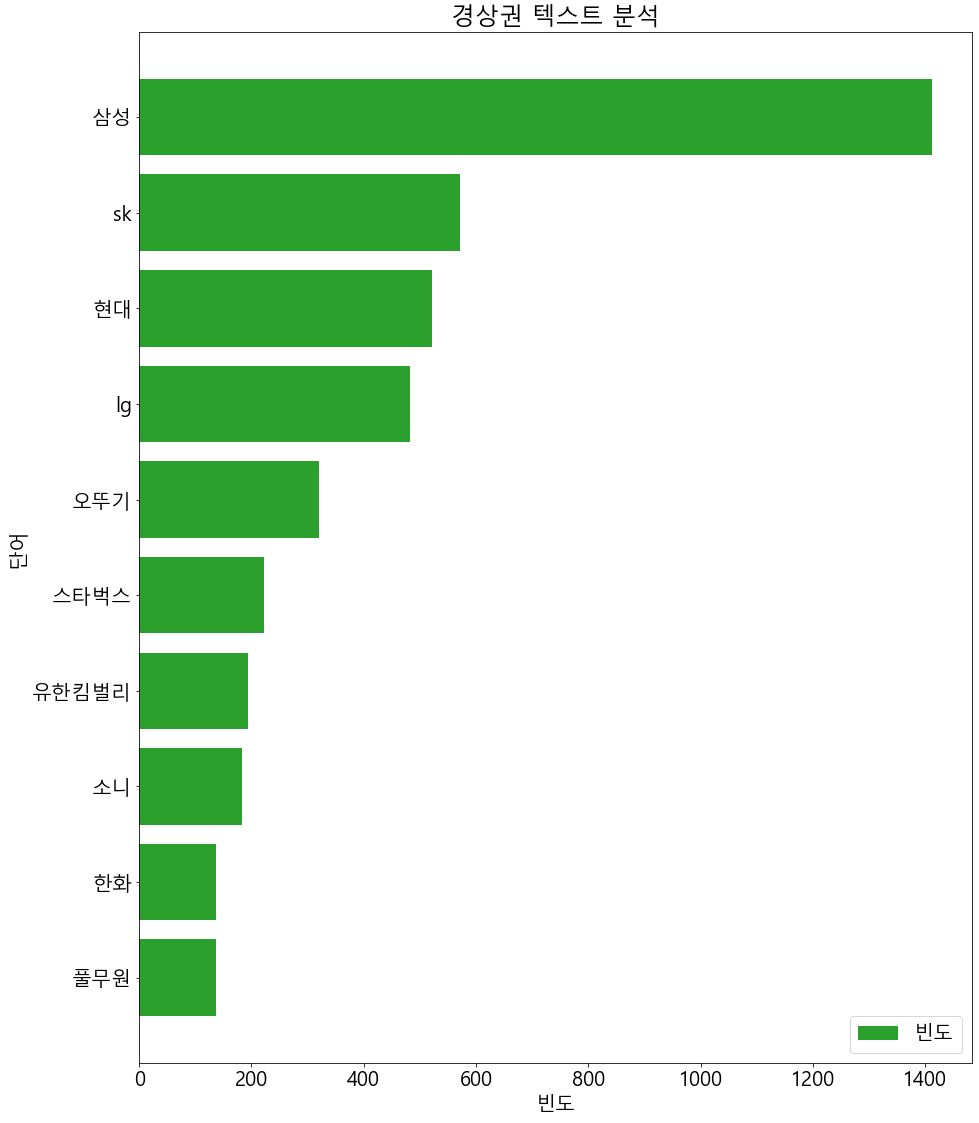

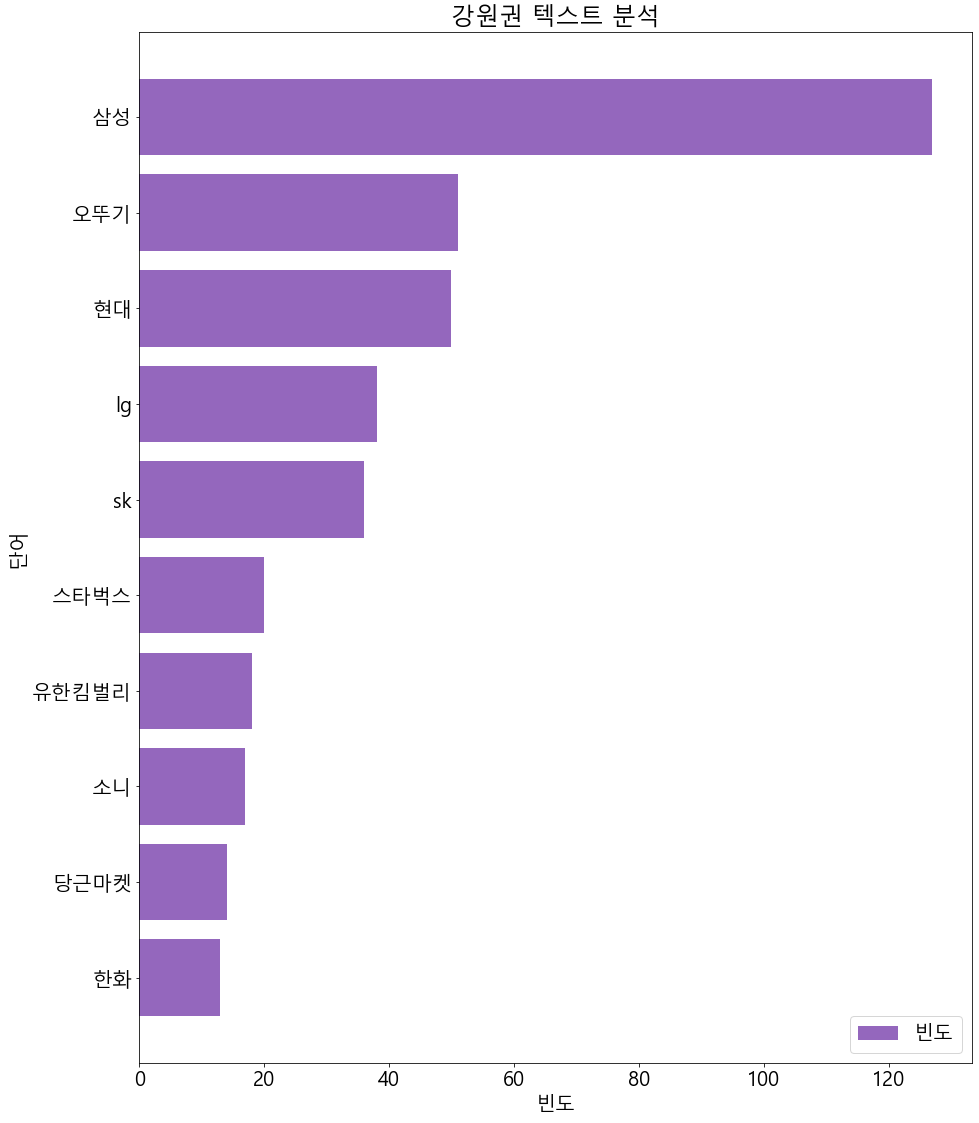

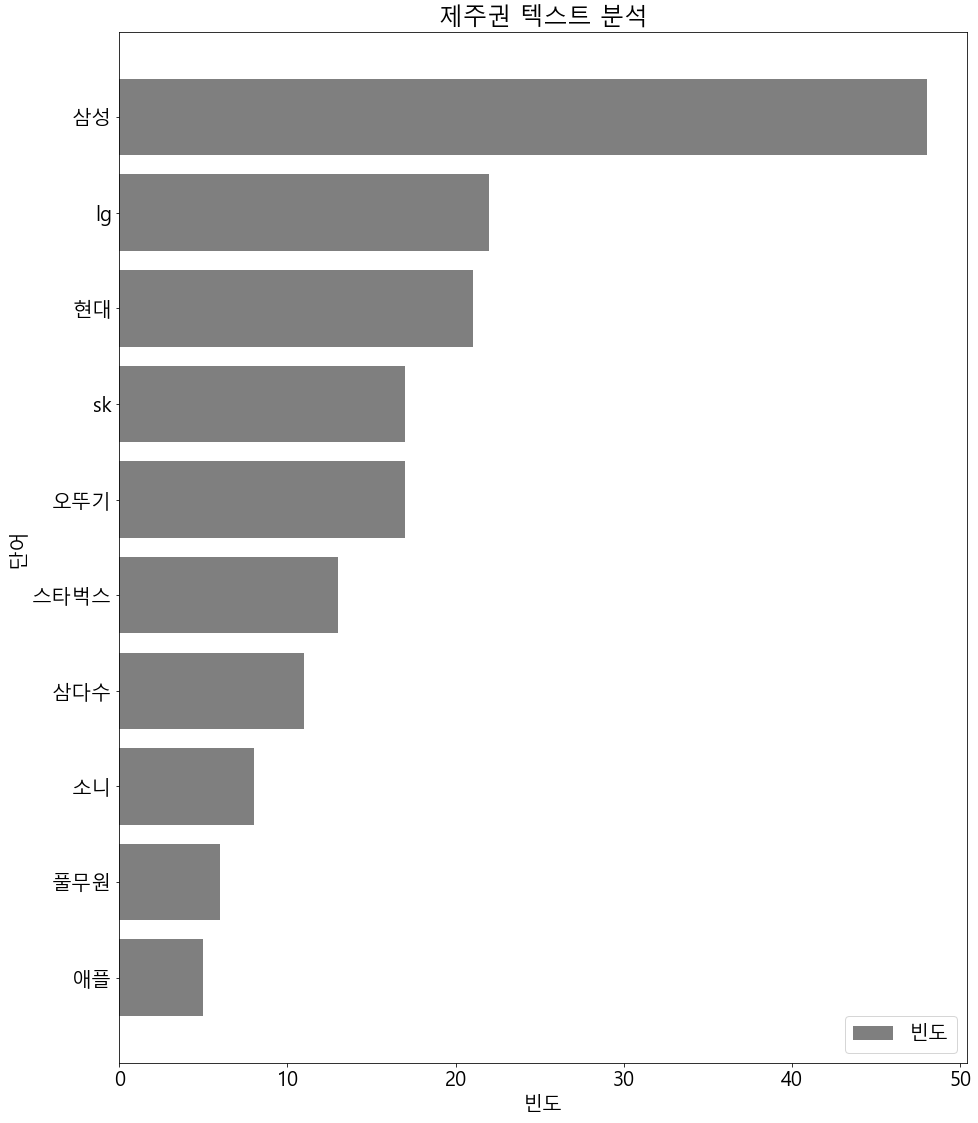

In [53]:
# Q1 지역별
bar_graph(sudo_q1_word, sudo_q1_vec, 'lightpink', '수도권')
bar_graph(choong_q1_word, choong_q1_vec, 'skyblue', '충청권')
bar_graph(junla_q1_word, junla_q1_vec, 'tab:orange', '전라권')
bar_graph(kyung_q1_word, kyung_q1_vec, 'tab:green', '경상권')
bar_graph(kang_q1_word, kang_q1_vec, 'tab:purple', '강원권')
bar_graph(jeju_q1_word, jeju_q1_vec, 'tab:gray', '제주권')

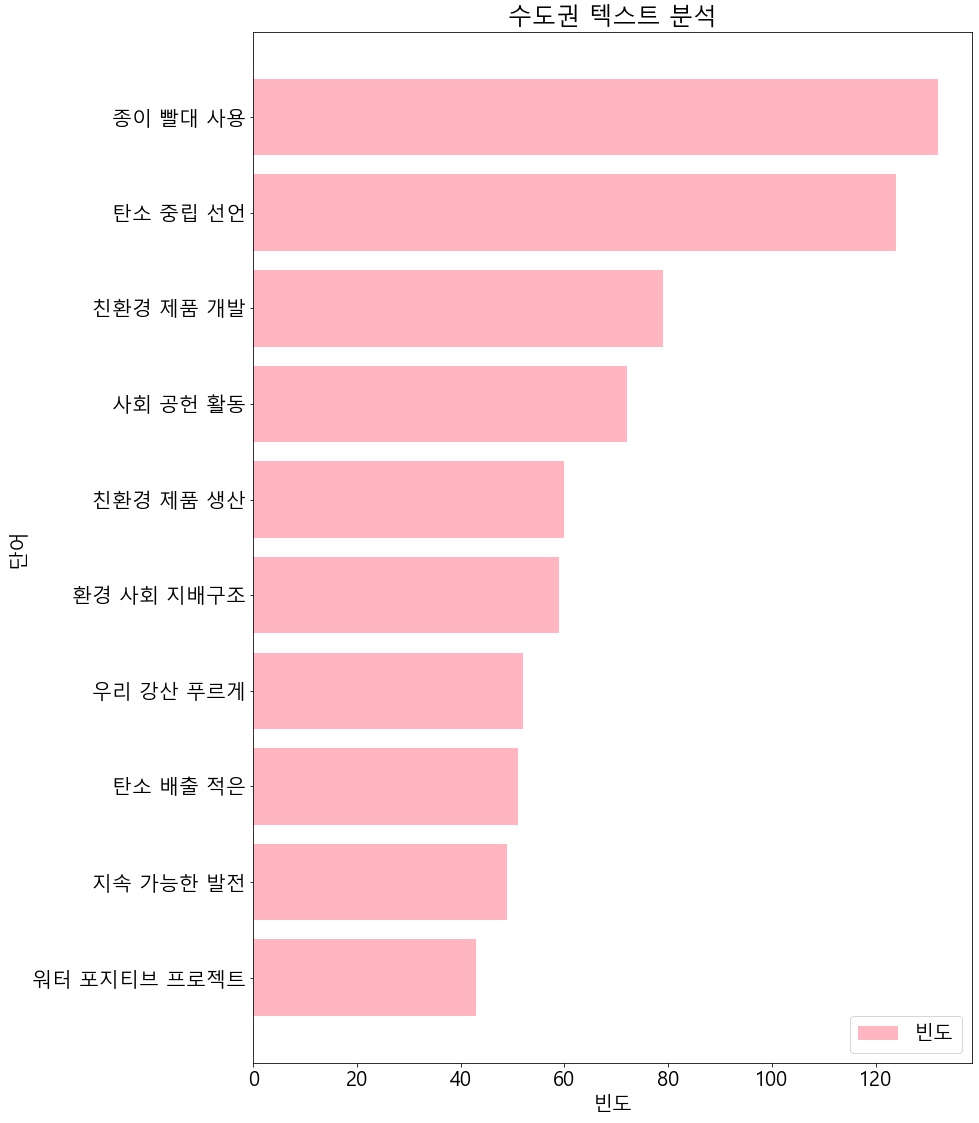

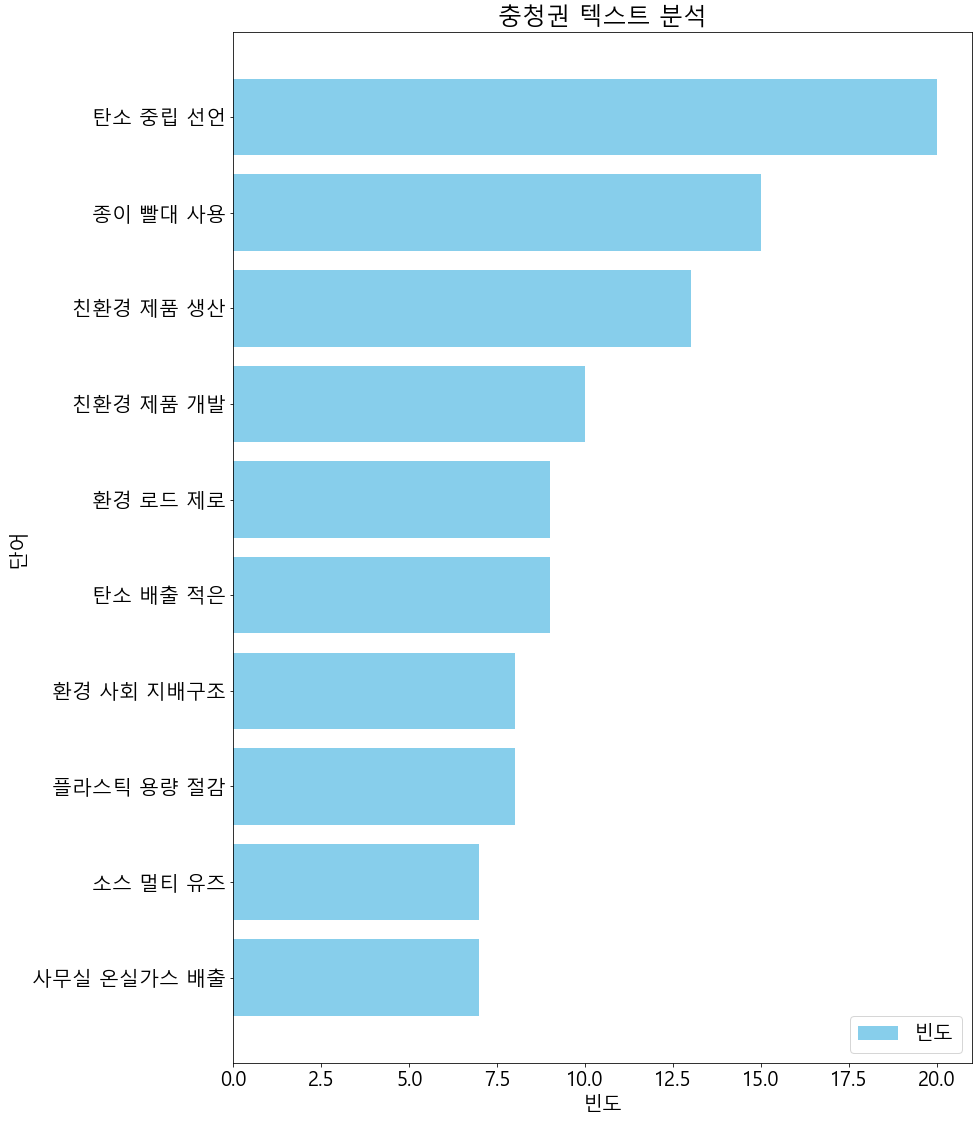

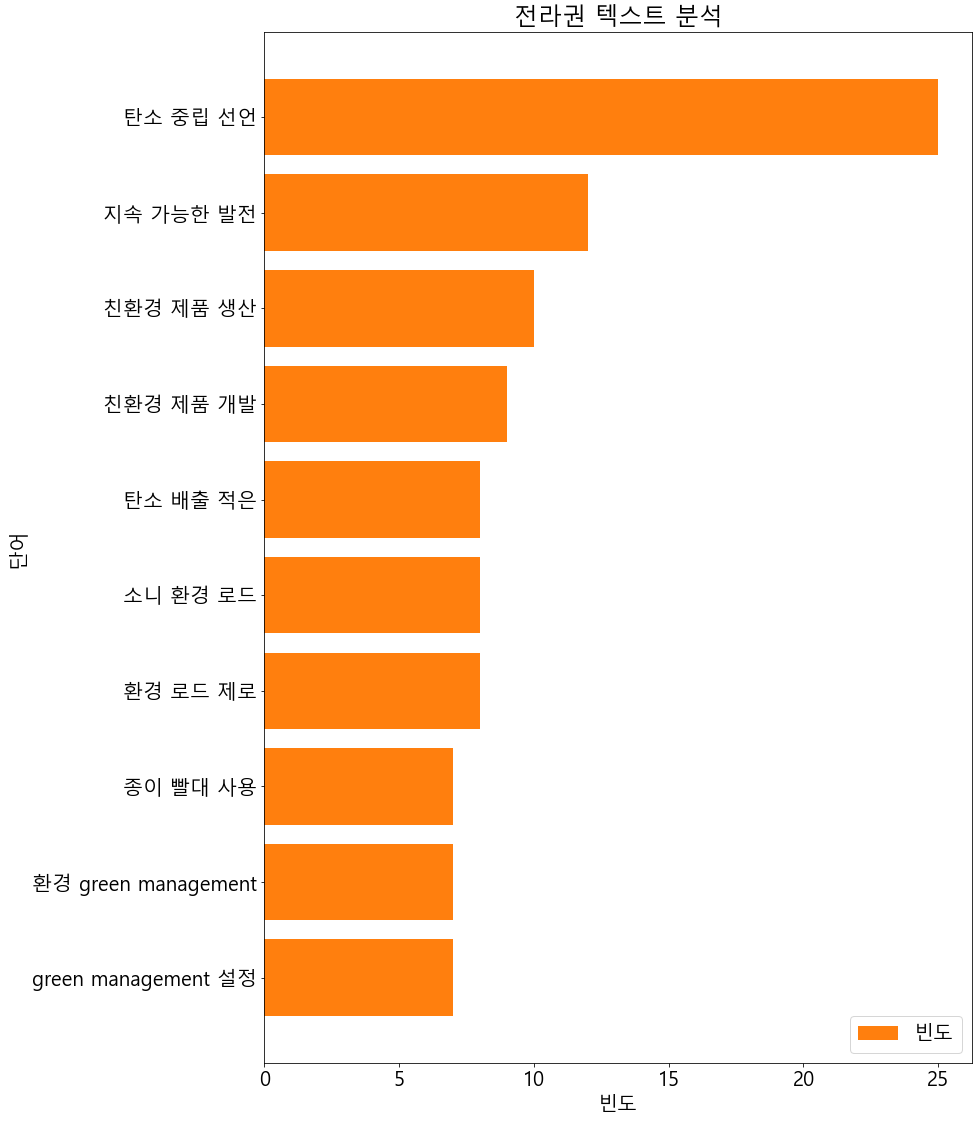

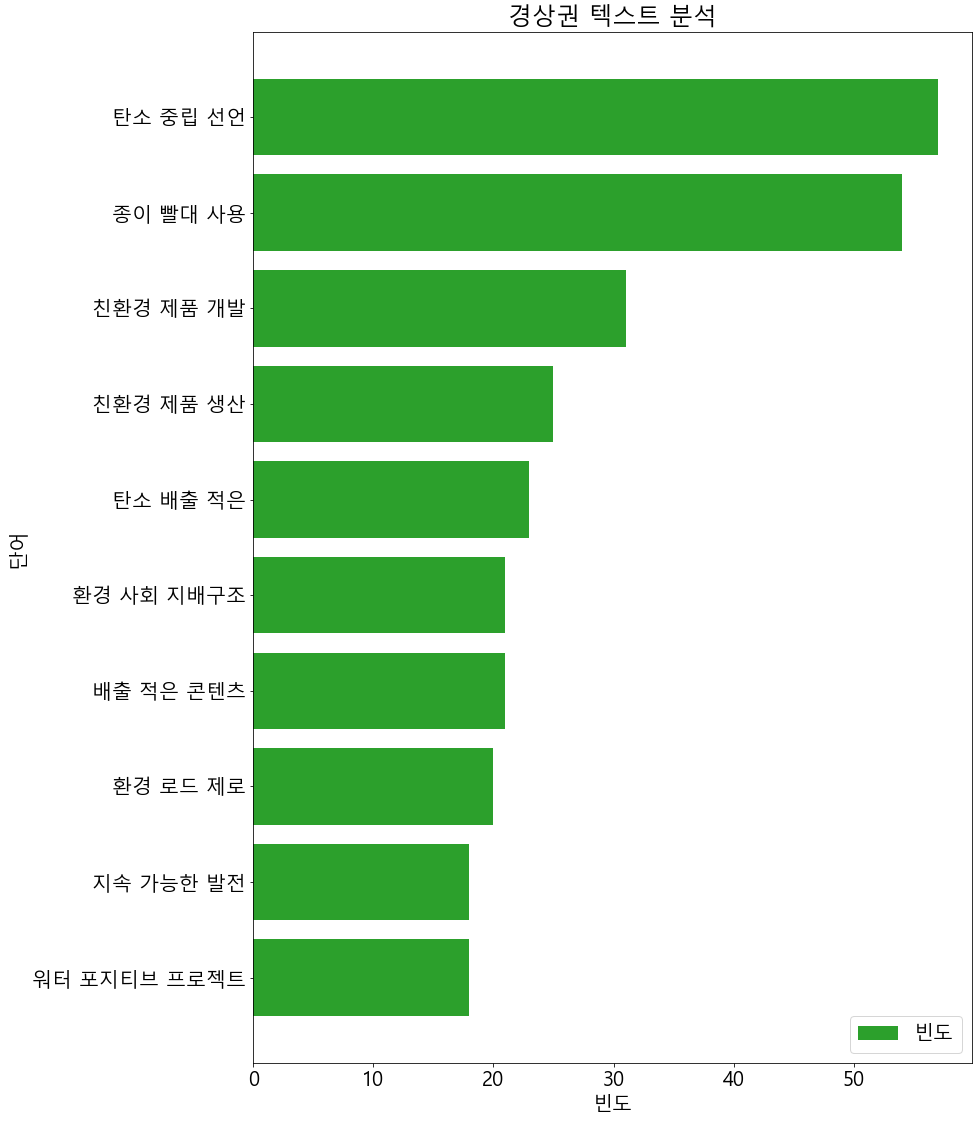

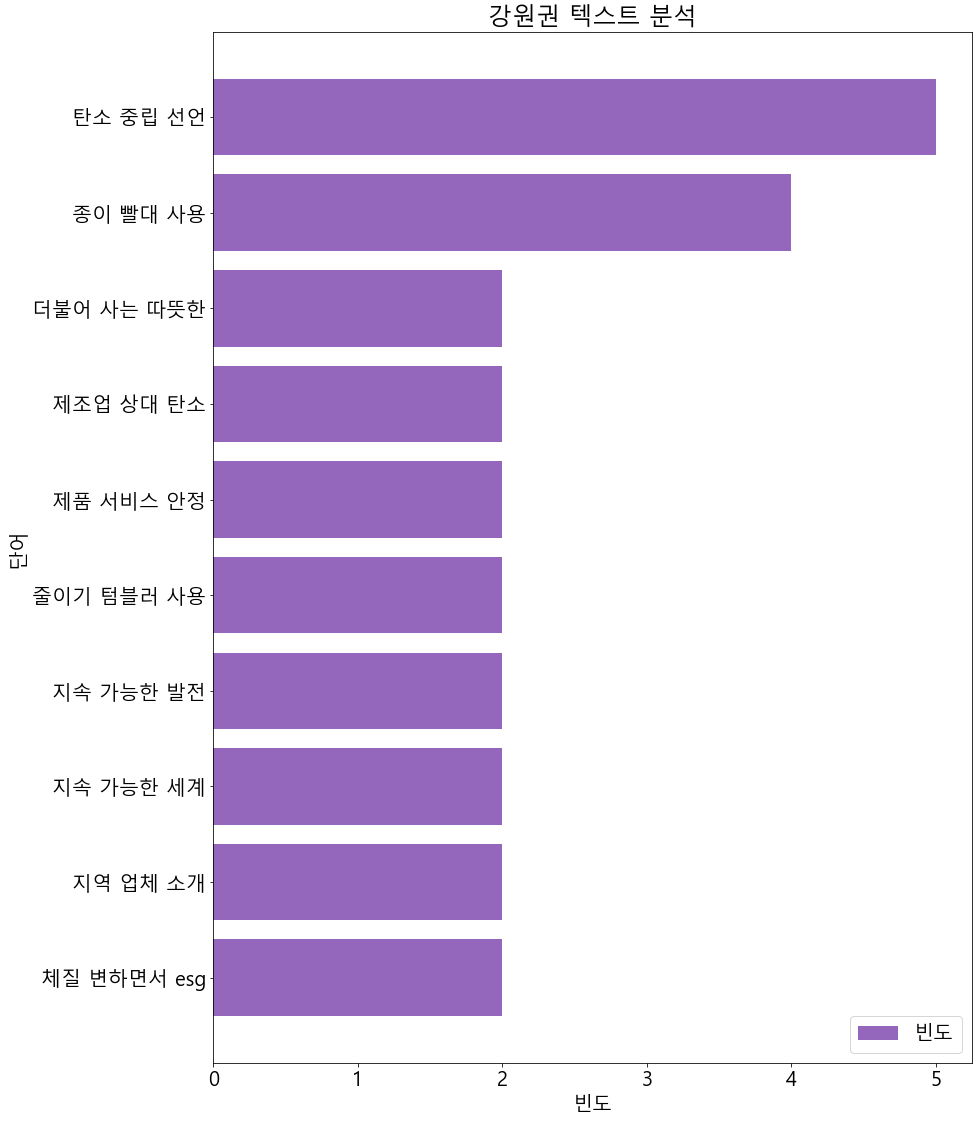

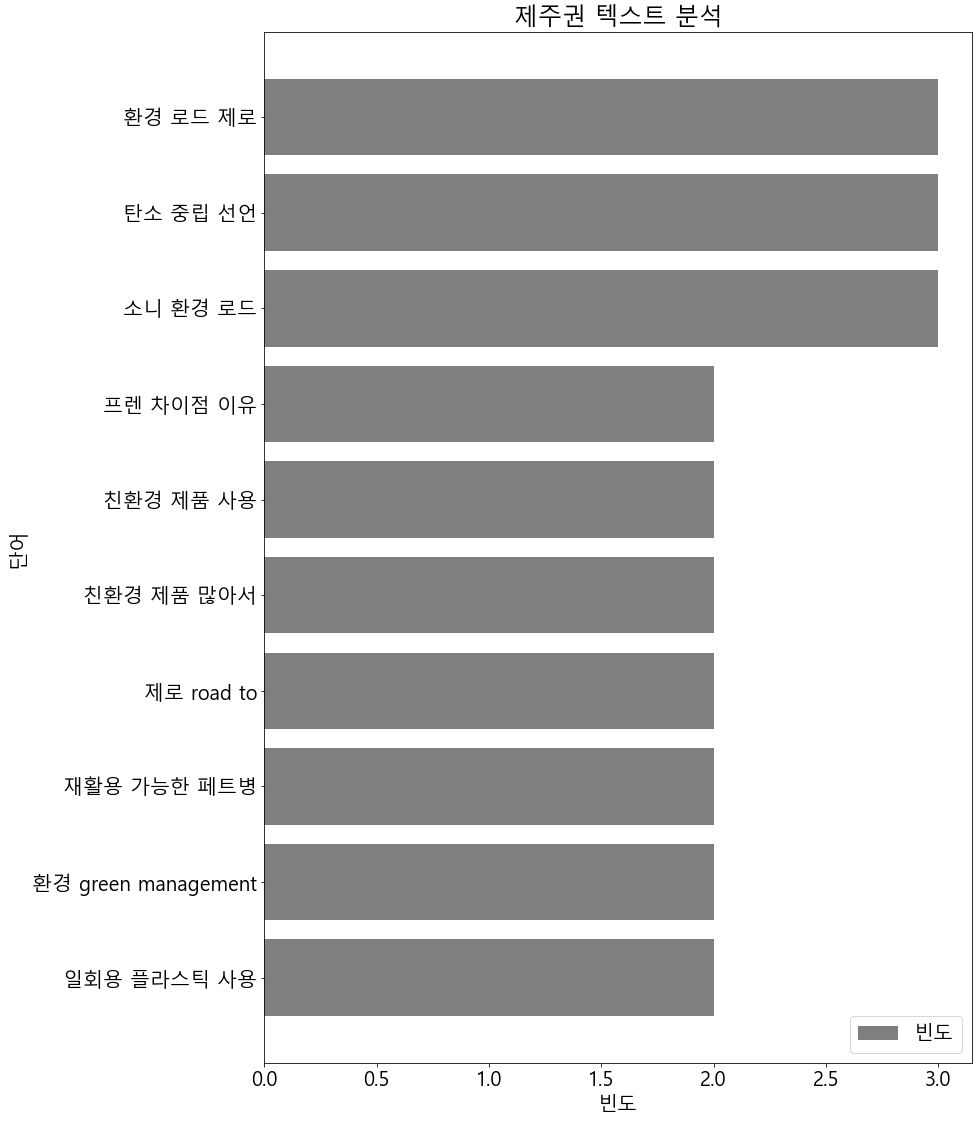

In [63]:
# Q2 지역별
bar_graph(sudo_q2_word, sudo_q2_vec, 'lightpink', '수도권')
bar_graph(choong_q2_word, choong_q2_vec, 'skyblue', '충청권')
bar_graph(junla_q2_word, junla_q2_vec, 'tab:orange', '전라권')
bar_graph(kyung_q2_word, kyung_q2_vec, 'tab:green', '경상권')
bar_graph(kang_q2_word, kang_q2_vec, 'tab:purple', '강원권')
bar_graph(jeju_q2_word, jeju_q2_vec, 'tab:gray', '제주권')

# 대표문장 추출

In [17]:
male = rep_texts(male_q2_word, male_q2, male_raw_data_q1, male_raw_data_q2, q2_count, '남자')
female = rep_texts(female_q2_word, female_q2, female_raw_data_q1, female_raw_data_q2, q2_count, '여자')

age10 = rep_texts(age10_q2_word, age10_q2, age10_raw_data_q1,age10_raw_data_q2, q2_count, '10대')
age20 = rep_texts(age20_q2_word, age20_q2, age20_raw_data_q1,age20_raw_data_q2, q2_count, '20대')
age30 = rep_texts(age30_q2_word, age30_q2, age30_raw_data_q1,age30_raw_data_q2, q2_count, '30대')
age40 = rep_texts(age40_q2_word, age40_q2, age40_raw_data_q1,age40_raw_data_q2, q2_count, '40대')
age50 = rep_texts(age50_q2_word, age50_q2, age50_raw_data_q1,age50_raw_data_q2, q2_count, '50대')
age60 = rep_texts(age60_q2_word, age60_q2, age60_raw_data_q1,age60_raw_data_q2, q2_count, '60대')

sudo = rep_texts(sudo_q2_word, sudo_q2, sudo_q1_raw, sudo_q2_raw, q2_count, '수도권')
choong = rep_texts(choong_q2_word, choong_q2, choong_q1_raw, choong_q2_raw, q2_count, '충청권')
junla = rep_texts(junla_q2_word, junla_q2, junla_q1_raw, junla_q2_raw, q2_count, '전라권')
kyung = rep_texts(kyung_q2_word, kyung_q2, kyung_q1_raw, kyung_q2_raw, q2_count, '경상권')
kang = rep_texts(kang_q2_word, kang_q2, kang_q1_raw, kang_q2_raw, q2_count, '강원권')
jeju = rep_texts(jeju_q2_word, jeju_q2, jeju_q1_raw, jeju_q2_raw, q2_count, '제주권')

In [18]:
male.to_csv('남자.csv', index=False, encoding='utf-8-sig')
female.to_csv('여자.csv', index=False, encoding='utf-8-sig')

age10.to_csv('10대.csv', index=False, encoding='utf-8-sig')
age20.to_csv('20대.csv', index=False, encoding='utf-8-sig')
age30.to_csv('30대.csv', index=False, encoding='utf-8-sig')
age40.to_csv('40대.csv', index=False, encoding='utf-8-sig')
age50.to_csv('50대.csv', index=False, encoding='utf-8-sig')
age60.to_csv('60대.csv', index=False, encoding='utf-8-sig')

sudo.to_csv('수도권.csv', index=False, encoding='utf-8-sig')
choong.to_csv('충청권.csv', index=False, encoding='utf-8-sig')
junla.to_csv('전라권.csv', index=False, encoding='utf-8-sig')
kyung.to_csv('경상권.csv', index=False, encoding='utf-8-sig')
kang.to_csv('강원권.csv', index=False, encoding='utf-8-sig')
jeju.to_csv('제주권.csv', index=False, encoding='utf-8-sig')